# Problem Set 5 Solutions

Please email mfe230e@gmail.com if you see any issues with these solutions

In [179]:
#from lib import *

#set_stuff()

import numpy as np
from sklearn.decomposition import PCA
### Import 'arch'
import arch
from arch import arch_model
from IPython.display import display, HTML

### Matplotlib imports
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates
from matplotlib import colors as mcolors
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()

### Import Pandas-related
import pandas as pd

from scipy.stats import beta, chi2, t, norm
import scipy.linalg
from scipy.linalg import toeplitz
import scipy.optimize
from scipy.optimize import minimize
import scipy.signal
import scipy as sp
import scipy.special
import scipy.stats



### statsmodels imports
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import multivariate
from statsmodels import regression, stats
from statsmodels.sandbox.regression import gmm
from statsmodels.sandbox.regression.gmm import GMM
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order

In [180]:
# Load in the dataframes

toSkipM25 = [i for i in range(11)]+[i for i in range(1132,6942)]
MoM25 = pd.read_csv('Data/25_Portfolios_ME_Prior_12_2.CSV',skiprows=toSkipM25)
toSkipMoM = [i for i in range(13)]+[i for i in range(1134,1232)]
MoM = pd.read_csv('Data/F-F_Momentum_Factor.CSV',skiprows=toSkipMoM)
toSkip5F = [i for i in range(3)]+[i for i in range(686,745)]
fiveFactor = pd.read_csv('Data/F-F_Research_Data_5_Factors_2x3.CSV',skiprows=toSkip5F)

# Tidy up the data a little bit before starting and make sure start of 
# sample is 1963 July
names = MoM25.columns.values
names[0]='Date'
MoM25.columns = names
MoM25['Date_str']=MoM25['Date'].apply(str)
MoM25['Date']=pd.to_datetime(MoM25['Date_str'],format='%Y%m')
MoM25=MoM25.drop(['Date_str'],1)
MoM25=MoM25[(pd.DatetimeIndex(MoM25['Date']).year>=1963)&((pd.DatetimeIndex(MoM25['Date']).year>1963)|(pd.DatetimeIndex(MoM25['Date']).month>=7))]

MoM.columns = ["Date",'MoM']
MoM['Date_str']=MoM['Date'].apply(str)
MoM['Date']=pd.to_datetime(MoM['Date_str'],format='%Y%m')
MoM=MoM.drop(['Date_str'],1)
MoM=MoM[(pd.DatetimeIndex(MoM['Date']).year>=1963)&((pd.DatetimeIndex(MoM['Date']).year>1963)|(pd.DatetimeIndex(MoM['Date']).month>=7))]

names=fiveFactor.columns.values
names[0]='Date'
fiveFactor.columns = names
fiveFactor['Date_str']=fiveFactor['Date'].apply(str)
fiveFactor['Date']=pd.to_datetime(fiveFactor['Date_str'],format='%Y%m')
fiveFactor=fiveFactor.drop(['Date_str'],1)



# Question 1
(a) For each of the 25 size-momentum portfolios, run the CAPM regression
$$
R_{i,t}− Rf_{t} = α_i + β_i(RM_t−Rf_t)+ \epsilon_{i,t}
$$

Report the 25 αi’s and βi’s along with their standard errors. Are the βi’s precisely estimated?

In [181]:
def CAPMregressions(df, stockBinNames,factorNames, addconstant,removeRf):

    #Declare X
    X=df[factorNames]
    if addconstant:
        X=sm.add_constant(X)

    # Create storage arrays
    β = np.zeros([len(stockBinNames),np.shape(X)[1]])
    seHom = np.zeros([len(stockBinNames),np.shape(X)[1]])
    seWhite = np.zeros([len(stockBinNames),np.shape(X)[1]])
    seNW = np.zeros([len(stockBinNames),np.shape(X)[1]])
    tStats = np.zeros([len(stockBinNames),np.shape(X)[1]])
    CAPMFitted = np.zeros([len(stockBinNames),np.shape(X)[0]])
    resid = np.zeros([len(stockBinNames),np.shape(X)[0]])

    
    regCount=0
    for nam in stockBinNames:
        if removeRf==True:
            Y=(df[nam]-df['RF'])
        else:
            Y=df[nam]
        reg=sm.OLS(Y,X)

        # run w 3 types of standard errors
        #results=reg.fit()
        #resultsWhite = reg.fit(cov_type = 'HC1')
        results = reg.fit(cov_type = 'HAC',cov_kwds={'maxlags':12})
        results_hom = reg.fit()

        β[regCount,:] = results.params
        seHom[regCount,:] = results_hom.bse
        seWhite[regCount,:] = results.HC1_se
        seNW[regCount,:] = results.bse
        # For part c) the "predicted values" assumes CAPM is correct which means we should assume that α=0. If we don't do
        # subtract α^hat here we will mechanically get everything on the 45 degree line since a property of OLS with a constant
        # is that the mean of the fitted values is exactly the mean of Y (as an exercise see if you can prove this by recalling
        # that α^hat = E[Y]-E[X]β; where here β is slope coefficients only).
        # To construct fitted values assuming $α=0$ requires taking the fittedvalue output from statsmodels and subtracting α
        CAPMFitted[regCount,:] = results.fittedvalues - results.params[0]  
        resid[regCount,:] = results.resid
                                                        
        

        regCount+=1

    return β,seHom,seWhite,seNW,CAPMFitted,resid

def niceOutput(β,se,seWhite,seNW,col2extract,thresh,varNam,showT):
    β = β[:,col2extract]
    se = se[:,col2extract]
    seWhite = seWhite[:,col2extract]
    seNW = seNW[:,col2extract]
    
    
    colNames = ['LowPrior','Prior2','Prior3','Prior4','Prior5']
    if showT==False:
        rowNames = ['Small','(se)','ME2','(se)','ME3','(se)','ME4','(se)','Big','(se)']
    else:
        rowNames = ['Small','(t-Stat)','ME2','(t-Stat)','ME3','(t-Stat)','ME4','(t-Stat)','Big','(t-Stat)']
    output_β = pd.DataFrame(columns = colNames,index=rowNames)
    output_β=output_β.reset_index()

    if len(colNames)*len(rowNames)/2 !=len(β):
        print('Error! The row and column names are not the same size as the array of regression coefficients')
        error()

    tStat = (β-thresh)/seNW
    
    if showT==True:
        t_hom = (β-thresh)/se
        t_het = (β-thresh)/seWhite
        t_NW = tStat
    
    countb=0
    
    for h in range(np.round(len(rowNames)/2).astype('int')):
        for w in range(len(colNames)):
            if abs(tStat[countb])> scipy.stats.norm.ppf(0.995):
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])+'***'
            elif abs(tStat[countb])> scipy.stats.norm.ppf(0.975):
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])+'**'
            elif abs(tStat[countb])> scipy.stats.norm.ppf(0.95):
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])+'*'
            else:
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])
            if showT==False:
                output_β.loc[2*h+1,colNames[w]] = '('+'{:.3f}'.format(se[countb])+','+'{:.3f}'.format(seWhite[countb])+','+\
                    '{:.3f}'.format(seNW[countb])+')'
            else:
                output_β.loc[2*h+1,colNames[w]] = '('+'{:.3f}'.format(t_hom[countb])+','+'{:.3f}'.format(t_het[countb])+','+\
                    '{:.3f}'.format(t_NW[countb])+')'


            countb+=1
    output_β=output_β.set_index('index')
    print("Results for "+varNam)
    display(HTML(output_β.to_html()))
    if showT==False:
        print('Standard errors are in the form (homoskedastic, White, Newey West(12))')
    else:
        print('t-Statistics are in the form (homoskedastic, White, Newey West(12))')
    print('*** = significantly different from '+str(thresh)+' at the 1% level (using NW)')
    print('** = significantly different from '+str(thresh)+' at the 5% level (using NW)')
    print('* = significantly different from '+str(thresh)+' at the 10% level (using NW)')
    return output_β,tStat








In [182]:
# get columns names for for loop of regressions
names2CAPM = MoM25.columns.values
names2CAPM = names2CAPM[1:]

# merge in a measure for the risk-free rate
if 'RF' not in names2CAPM:
    MoM25=pd.merge(MoM25,fiveFactor,on='Date',how='outer',indicator=True)
    # check merge was perfect
    if any(MoM25['_merge']!="both"):
        error()
    # drop unneeded columns
    MoM25=MoM25.drop(['SMB','HML','RMW','CMA','_merge'],1)
else: 
    names2CAPM = [item for item in names2CAPM.tolist() if item not in ['Mkt-RF','RF']]

##################### Regression time!####################################
β,se,seWhite,seNW,CAPMfitted,resid = CAPMregressions(MoM25, names2CAPM,'Mkt-RF',True,True)


######################Nice Table Output##################################
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=1,thresh=1,varNam='β',showT=False)






Results for β


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,1.391***,1.065,1.011,1.011,1.216***
(se),"(0.045,0.059,0.072)","(0.031,0.045,0.053)","(0.028,0.041,0.047)","(0.028,0.039,0.044)","(0.035,0.043,0.051)"
ME2,1.467***,1.144***,1.045,1.063,1.289***
(se),"(0.038,0.054,0.074)","(0.027,0.040,0.049)","(0.022,0.035,0.040)","(0.023,0.035,0.040)","(0.030,0.036,0.046)"
ME3,1.387***,1.119***,1.032,1.021,1.219***
(se),"(0.036,0.052,0.075)","(0.023,0.033,0.042)","(0.020,0.031,0.043)","(0.019,0.030,0.039)","(0.027,0.032,0.044)"
ME4,1.366***,1.123***,1.018,1.000,1.145***
(se),"(0.037,0.062,0.089)","(0.022,0.030,0.046)","(0.017,0.025,0.036)","(0.015,0.021,0.030)","(0.025,0.029,0.039)"
Big,1.254***,0.946,0.907***,0.886***,1.015


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)


> *The tables here present the $\beta$ coefficients and standard erros in brackets (all three of homoskedastic, White and Newey West with 12 lags). I use a convention common in economics papers to use asterixes (* * *) above coefficients to denote significance. Here I use them for a significance test from 1 instead of from 0 as this is a more interesting benchmark for the CAPM tests (becuase we want to know if a grouping has a covariance with the market noticably different to 1 rather than 0 typically).* 
>
> *The results here seem to suggest that firms of all sizes in lowest 2 prior performance bins and the largest perio performance bin have very large $\beta$s. Some large firms also have some $\beta$s significantly above 1 as well. 
>
> *Note also that the $\beta$ estimates are fairly precisely estimated. The largest (i.e. least precise) Newey West standard error is 0.089 which means we can separate a $\beta$ of 1.1 from 1. I would claim that difference boarders on economically noticeable so the estimates here can be said to be precise*

(b) Are the pricing errors (ˆαi’s) statistically and economically significant? What do you conclude?

In [183]:
niceOutput_α,tStat_α=niceOutput(β,se,seWhite,seNW,col2extract=0,thresh=0,varNam='α',showT=False)

Results for α


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.730***,0.062,0.359**,0.468***,0.641***
(se),"(0.200,0.189,0.212)","(0.136,0.132,0.167)","(0.124,0.123,0.163)","(0.122,0.124,0.167)","(0.155,0.156,0.202)"
ME2,-0.641***,0.049,0.239*,0.384***,0.472***
(se),"(0.170,0.160,0.181)","(0.119,0.116,0.141)","(0.100,0.100,0.127)","(0.104,0.104,0.130)","(0.135,0.135,0.154)"
ME3,-0.503***,-0.013,0.141,0.191*,0.489***
(se),"(0.162,0.158,0.175)","(0.100,0.099,0.123)","(0.088,0.088,0.119)","(0.085,0.087,0.108)","(0.120,0.120,0.140)"
ME4,-0.555***,-0.024,0.107,0.247***,0.413***
(se),"(0.164,0.165,0.168)","(0.097,0.095,0.105)","(0.075,0.075,0.102)","(0.068,0.069,0.087)","(0.109,0.109,0.107)"
Big,-0.507***,-0.015,-0.036,0.085,0.259***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using NW)
** = significantly different from 0 at the 5% level (using NW)
* = significantly different from 0 at the 10% level (using NW)


> *The table above shows the $\alpha$ estimates results now with asterixes (* * *) denoting significance from 0. As can be seen 14% of estimates are significantly different from 0 at the 1% level.*
>
> *In terms of precision, the (Newey West) standard errors range from 0.058 - 0.212. A 0.212 $\alpha$ at a monthly level corresponds to a annual return differnce of 0.212 *12 $\approx$ 2.5% --  a noticeable margin to not necessarily be able to distinguish. The fact we reject so often is because the $\alpha$s we find are very very large (i.e. economically significant).*
>
> *the standard errors do tend to be much smaller for the coefficients where the null hypothetsis is not rejected. Here the standard errors range from .058 - .167. However, even a standard error of 0.058 corresponds to a 0.7% return difference annually. This is not huge but not small either.*


(c) Plot the fitted mean excess returns on the x-axis and the average excess returns on the y-axis.
What does this plot say about the fit of the model?

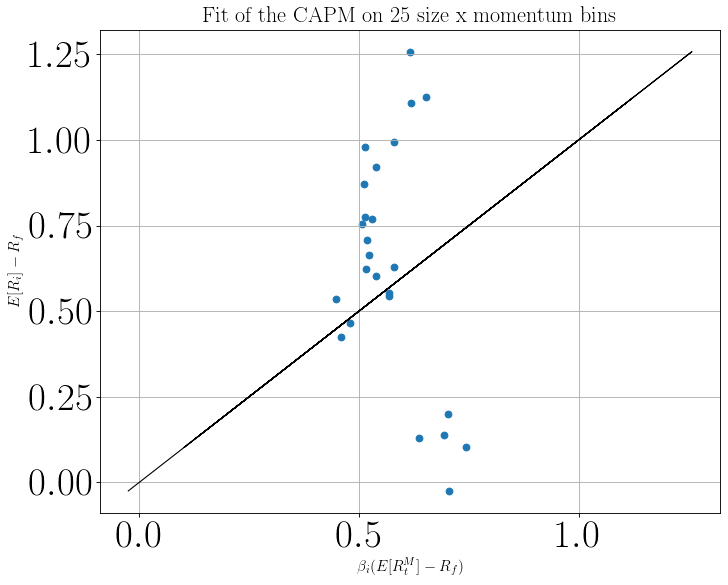

In [184]:
df=MoM25.copy()

rc('text',usetex=True)

for nam in names2CAPM:
    df[nam]=df[nam]-df['RF']
df=df[names2CAPM]

#def plotMeanFitted(yHat,df):
    # First we need to take averages across all time
    
yHatdf = pd.DataFrame(data = np.matrix(CAPMfitted).T)
yHatdf.columns = names2CAPM
yHatMean = yHatdf.mean()
dataMean = df.mean()
fig = plt.figure(figsize=(10, 8), dpi= 80)
ax = fig.gca()
plt.scatter(yHatMean,dataMean)
plt.plot(dataMean,dataMean,color='black',linewidth=1)
ax.grid('false')
ax.set_xlabel(r'$\beta_i(E[R_t^M]-R_f$)',fontsize=14)
ax.set_ylabel(r'$E[R_i]-R_f$',fontsize=14)
ax.set_title('Fit of the CAPM on 25 size x momentum bins',fontsize=20)
plt.show()

> *AS can be seen in the graph, the $\alpha$s (vertical distance between a dot and the 45 degree line) are sizeable. This suggests a fairly bad fit of the CAPM. Worse than for the Book-to-market/Size bins shown in class*

(d) Compute t-tests for the null H0 : αi = 0 for each αi individually.

>* This was already done above for the $\alpha$ plots where I determined the number of asterixes with a t-test. For those that want to compare their t-statistics with mine, I now replace the standard errors with t-stats:


In [185]:
niceOutput_α,tStat_α=niceOutput(β,se,seWhite,seNW,col2extract=0,thresh=0,varNam='α',showT=True)

Results for α


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.730***,0.062,0.359**,0.468***,0.641***
(t-Stat),"(-3.643,-3.863,-3.449)","(0.458,0.473,0.374)","(2.886,2.922,2.198)","(3.824,3.787,2.803)","(4.129,4.109,3.176)"
ME2,-0.641***,0.049,0.239*,0.384***,0.472***
(t-Stat),"(-3.772,-4.000,-3.548)","(0.412,0.423,0.349)","(2.389,2.379,1.875)","(3.705,3.676,2.960)","(3.487,3.498,3.064)"
ME3,-0.503***,-0.013,0.141,0.191*,0.489***
(t-Stat),"(-3.102,-3.185,-2.876)","(-0.132,-0.135,-0.108)","(1.615,1.615,1.189)","(2.258,2.201,1.770)","(4.063,4.058,3.487)"
ME4,-0.555***,-0.024,0.107,0.247***,0.413***
(t-Stat),"(-3.379,-3.358,-3.298)","(-0.253,-0.256,-0.233)","(1.426,1.418,1.043)","(3.664,3.587,2.856)","(3.783,3.807,3.855)"
Big,-0.507***,-0.015,-0.036,0.085,0.259***


t-Statistics are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using NW)
** = significantly different from 0 at the 5% level (using NW)
* = significantly different from 0 at the 10% level (using NW)


(e) Compute the GRS test for the joint null H0 : $\alpha_i = 0 \;\forall i$.

> *There are two ways to calculate this GRS test:*
>
> 1. *Using:$$
T\frac{\hat{\mathbf{\alpha}}'\hat{\mathbf{\Sigma}}\hat{\mathbf{\alpha}}}{1+\hat{SR}_M^2}\rightarrow \chi_N^2
$$*
> 2. *Using:$$
T\frac{\hat{SR}_{N,M}^2-\hat{SR}_M^2}{1+\hat{SR}_M^2}\rightarrow \chi_N^2
$$*
> *Here I will do both*

In [186]:
def SharpePort(weights,means,VCov):
    weights=np.matrix(weights.tolist() +[1-sum(weights)]).T
    means = weights.T@np.matrix(means).T
    stds = np.sqrt(weights.T@VCov@weights)
    
    toRet = -means/stds
    return toRet.A1[0]

def findVCov(data,varlist):
    
    toVCov = data[varlist]
    demeaned = np.matrix(toVCov.values)-np.ones((len(toVCov),1))@np.matrix(toVCov.mean())
    
    VCov = (demeaned.T@demeaned)/(np.shape(toVCov)[0])
    return VCov


# get actual residuals


# Error-Variance Covariacne Matrix
T=resid.shape[1]
Σ = np.matrix((resid@resid.T)/T)

Sn = MoM25['Mkt-RF'].mean()/MoM25['Mkt-RF'].std()

GRSstat = T*(np.matrix(β[:,0])@Σ.I@np.matrix(β[:,0]).T/(1+Sn**2)).A1[0]
crit99 = scipy.stats.distributions.chi2.ppf(0.99,Σ.shape[0])
crit95 = scipy.stats.distributions.chi2.ppf(0.95,Σ.shape[0])
print('GRS','    crit99','crit95')
print('{:.0f}'.format(GRSstat),'    {:.0f}'.format(crit99),'     {:.0f}'.format(crit95))

if GRSstat > crit99:
    print('We reject that every α=0 at the 1% level')
elif GRSstat > crit95:
    print('We reject that every α=0 at the 5% level')
else:
    print('We fail to reject that every α=0 at the 5% level')

    

frontierNames = names2CAPM.tolist()+['Mkt-RF']


toOptimize = MoM25.copy()
for nam in names2CAPM:
    toOptimize[nam]=toOptimize[nam]-toOptimize['RF']
toOptimize=toOptimize[frontierNames]

weights = np.array([1/(len(frontierNames)) for i in range(len(frontierNames)-1)])

VCov = findVCov(toOptimize,frontierNames)

means = toOptimize.mean()


temp = SharpePort(weights,means,VCov)
res=scipy.optimize.minimize(SharpePort,weights,args=(means,VCov))
weightsOpt = res.x
weightsOpt=weightsOpt.tolist() +[1-sum(weightsOpt)]

SharpeOpt = res.fun*(-1)
GRS_2 = T*(SharpeOpt**2-Sn**2)/(1+Sn**2)

print('*******************************************************************************')
print('GRS_2','    crit99','crit95')
print('{:.0f}'.format(GRS_2),'    {:.0f}'.format(crit99),'     {:.0f}'.format(crit95))

if GRS_2 > crit99:
    print('We reject that every α=0 at the 1% level')
elif GRS_2 > crit95:
    print('We reject that every α=0 at the 5% level')
else:
    print('We fail to reject that every α=0 at the 5% level')
if np.abs(GRSstat-GRS_2)>0.1:
    print('The GRS statistics are not the same! Error?!?')
    print('Max Sharpe Ratio should be: {:.3f}'.format(np.sqrt((135*(1+Sn**2)+T*Sn**2)/T)))
    print('But is calculated as: {:.3f}'.format(SharpeOpt))
else:
    print('And both GRS statistics are the same. Praise Providence!')

GRS     crit99 crit95
135     44      38
We reject that every α=0 at the 1% level
*******************************************************************************
GRS_2     crit99 crit95
135     44      38
We reject that every α=0 at the 1% level
And both GRS statistics are the same. Praise Providence!


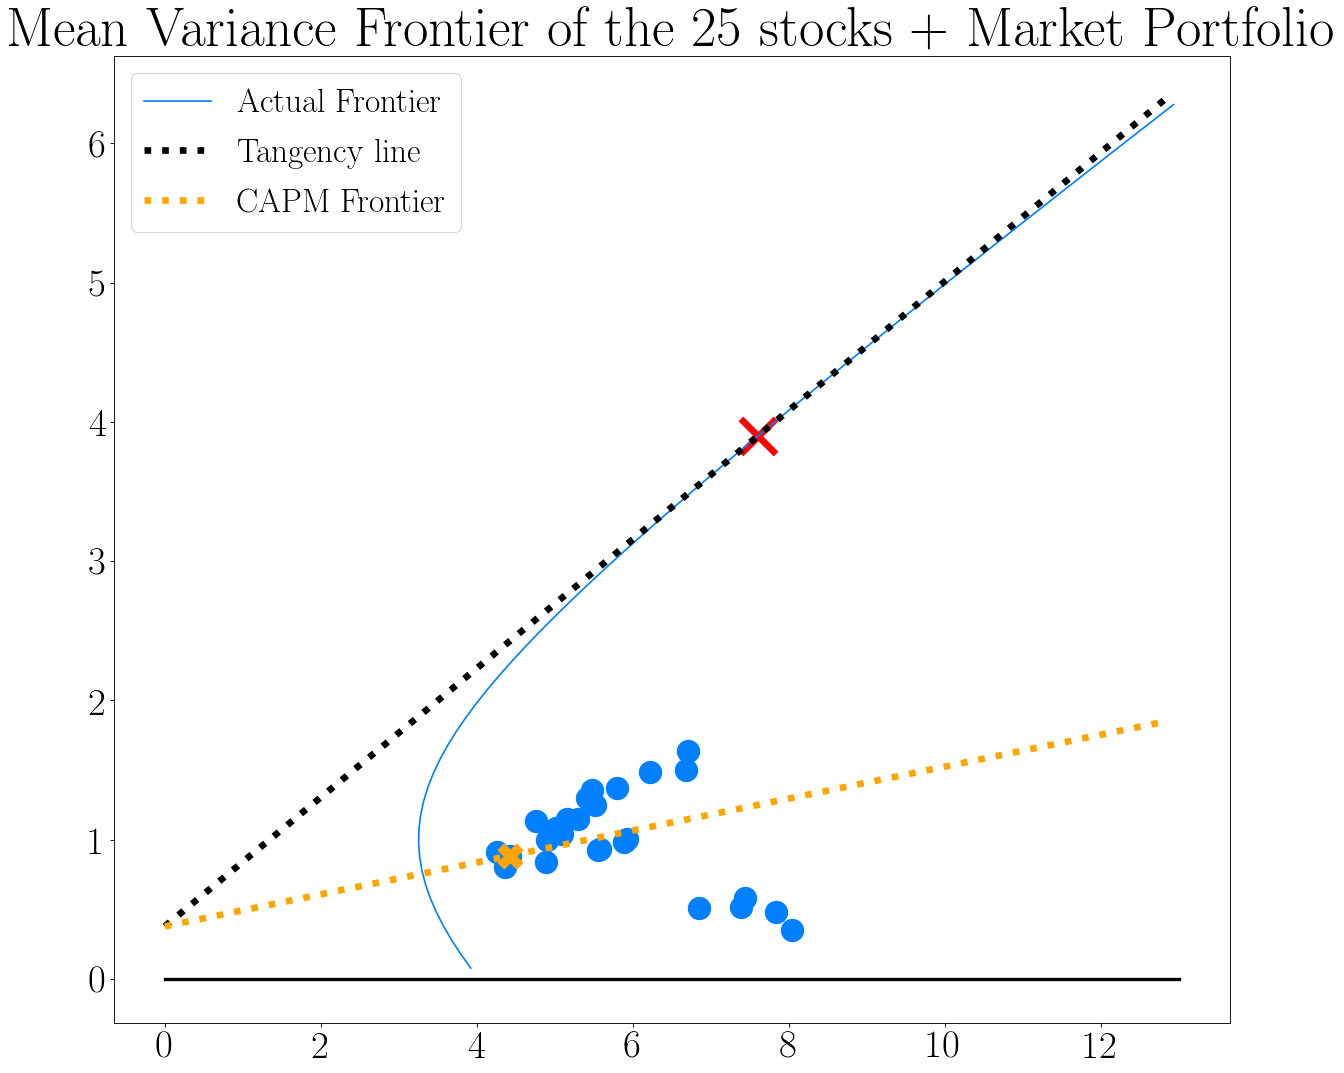

In [187]:
from scipy.optimize import LinearConstraint
# Now do the portfolio plot
def minVar(weights,VCov):
    weights=np.matrix(weights.tolist() +[1-sum(weights)]).T
    return np.sqrt(weights.T@VCov@weights)

def meanConstraint(weights,means,meanLimit):
    weights=np.matrix(weights.tolist() +[1-sum(weights)]).T
    return means.dot(weights)-meanLimit

   
def findTangency(x,SharpeOpt,varLimits,meanLimits):
    closest_value = np.argmin(np.abs(np.array(varLimits)-x))
    if closest_value==0:
        nextClosestValue = closest_value+1
    elif (closest_value==(len(varLimits)-1))|(closest_value==(len(varLimits))):
        nextClosestValue = closest_value-1
    else:
        if (x>varLimits[closest_value]):
            nextClosestValue = closest_value+1
        else:
            nextClosestValue = closest_value-1
    weight_closest = (x-varLimits[nextClosestValue])/(varLimits[closest_value]-varLimits[nextClosestValue])
    interpolate_mean = weight_closest*meanLimits[closest_value]+(1-weight_closest)*meanLimits[nextClosestValue]
    return (SharpeOpt*x-interpolate_mean)**2

def findFrontier(meanLimits,varNames,VCov,means):
    varLimits = [0 for meanLimit in meanLimits]
    count = 0
    for meanLimit in meanLimits:
        mean_constraint =  {'type':'eq', 'fun': meanConstraint,'args' : (means,meanLimit)}
        weights = np.array([0/(len(varNames)) for i in range(len(varNames)-1)])
        res=scipy.optimize.minimize(minVar,weights,args=(VCov),constraints=mean_constraint,method='SLSQP')
        varLimits[count] = res.fun
        count=count+1
    return varLimits

# Rf
Rf=MoM25['RF'].mean()
meanLimits = np.arange(-0.3,6,0.1)
varLimits = findFrontier(meanLimits,frontierNames,VCov,means)
res=scipy.optimize.minimize(findTangency,5,args=(SharpeOpt,varLimits,meanLimits))


font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 35}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1,figsize=(18, 16),dpi=80)
    
#plotting!!!
ax.scatter(np.sqrt(np.diag(VCov)),Rf+means,color=(0,0.5,1),s=400,label='_nolegend_') # portfolios
ax.plot(varLimits,Rf+meanLimits,color=(0,0.5,1))  # frontier
ax.plot([0,round(max(varLimits))],[0,0],color='black',linewidth=3,label='_nolegend_') # zero line
vols = np.arange(0,max(varLimits),0.2)
tmp=ax.plot(vols,Rf+SharpeOpt*vols,color='black',linestyle=':',linewidth=6)
ax.scatter(res.x,Rf+SharpeOpt*res.x,marker='x',color='red',s=1000,linewidth=6)
# Plot market
plt.scatter(MoM25['Mkt-RF'].std(),MoM25['Mkt-RF'].mean()+Rf,marker='X',color='orange',s=500)
MarketSharpe = MoM25['Mkt-RF'].mean()/MoM25['Mkt-RF'].std()
tmp2=ax.plot(vols, Rf+ MarketSharpe*vols,color='orange',linestyle=":",linewidth=6)
ax.set_title('Mean Variance Frontier of the 25 stocks + Market Portfolio',fontsize=50)
ax.legend(['Actual Frontier','Tangency line','CAPM Frontier'],fontsize=30)
plt.show()

(g) Summarize how well the CAPM model explains the 25 test portfolios.

> *As can be seen the Frontier spanned by the 25 Momentum Stocks is much much more expansive than that implied by the CAPM. Lets now take stock of all the CAPM predictions:*
> 1. *$\alpha$s: large and significant for more than half of the 5 x 5 portfolio bins. CAPM predicts that these should be 0.*
> 2. *GRS Test: Calculated both ways and we reject that all the $\alpha$s are 0.*
> 3. *MV frontier clearly dominated in economic terms by including the additional 25 portfolio bins. Not good for CAPM*

# Question 2

Now, consider the 3-factor Fama-French model. For each asset, run the following regression:
$$
R_{i,t}− R_t^f= \alpha_i + \beta_{MKT,i}(R_t^M-R^f_t)+ \beta_{SMB,i}R^{SMB}_t + \beta_{HML,i}R^{HML}_t + \epsilon_{i,t}
$$

Repeat the exercise in Question 1.

> *It shall be done!*
> *Starting with part a) *


In [198]:
# First we need to merge the 25 portfolio bins with the 3 Factor data:
Mom25_=MoM25.copy()
# delete some variables from MoM25 that will be readded
Mom25_=Mom25_.drop(columns=['Mkt-RF','RF'])

# Check merge carefully
checkMerge = False
if checkMerge==True:
    data = pd.merge(Mom25_,fiveFactor,on="Date",how='outer',indicator=True)
    print(data.groupby('_merge').count())
else:
    data = pd.merge(Mom25_,fiveFactor,on="Date",how='inner')


names2Factor = [item for item in  data.columns.values.tolist() if item not in ['SMB','HML','RMW','CMA','RF','Mkt-RF','Date']]
##################### Regression time!####################################
β,se,seWhite,seNW,Factorfitted,resid = CAPMregressions(data, names2Factor,['Mkt-RF','SMB','HML'],True,True)


######################Nice Table Output##################################
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=1,thresh=1,varNam='β Mkt-RF',showT=False)
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=2,thresh=1,varNam='β SMB',showT=False)
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=3,thresh=1,varNam='β HML',showT=False)

Results for β Mkt-RF


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,1.184***,0.925**,0.882***,0.863***,0.980
(se),"(0.034,0.046,0.063)","(0.017,0.023,0.031)","(0.015,0.019,0.021)","(0.014,0.019,0.022)","(0.021,0.028,0.026)"
ME2,1.308***,1.036,0.949***,0.944***,1.078***
(se),"(0.031,0.048,0.066)","(0.018,0.024,0.029)","(0.013,0.016,0.018)","(0.012,0.015,0.020)","(0.019,0.025,0.026)"
ME3,1.297***,1.070**,0.985,0.969,1.048*
(se),"(0.035,0.052,0.069)","(0.018,0.027,0.028)","(0.014,0.018,0.018)","(0.015,0.021,0.024)","(0.021,0.024,0.029)"
ME4,1.350***,1.133***,1.025,0.990,1.030
(se),"(0.037,0.060,0.079)","(0.021,0.028,0.031)","(0.015,0.021,0.023)","(0.015,0.020,0.025)","(0.023,0.028,0.032)"
Big,1.314***,1.020,0.969,0.938**,0.989


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)
Results for β SMB


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,1.239**,0.973,0.904,0.923**,1.156***
(se),"(0.049,0.086,0.096)","(0.024,0.053,0.074)","(0.021,0.046,0.067)","(0.020,0.031,0.037)","(0.030,0.056,0.045)"
ME2,0.952,0.778***,0.693***,0.767***,0.964
(se),"(0.045,0.069,0.085)","(0.025,0.051,0.078)","(0.019,0.033,0.058)","(0.018,0.027,0.043)","(0.028,0.048,0.053)"
ME3,0.618***,0.481***,0.471***,0.454***,0.725***
(se),"(0.050,0.084,0.111)","(0.026,0.053,0.084)","(0.021,0.038,0.061)","(0.021,0.038,0.063)","(0.030,0.044,0.053)"
ME4,0.329***,0.186***,0.181***,0.174***,0.446***
(se),"(0.053,0.078,0.098)","(0.030,0.055,0.087)","(0.022,0.045,0.080)","(0.021,0.043,0.064)","(0.033,0.055,0.063)"
Big,-0.111***,-0.191***,-0.200***,-0.218***,-0.025***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)
Results for β HML


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,0.253***,0.365***,0.347***,0.231***,-0.073***
(se),"(0.050,0.088,0.116)","(0.025,0.046,0.063)","(0.021,0.036,0.054)","(0.021,0.031,0.046)","(0.031,0.046,0.051)"
ME2,0.195***,0.314***,0.284***,0.221***,-0.163***
(se),"(0.046,0.079,0.123)","(0.026,0.047,0.077)","(0.019,0.031,0.061)","(0.018,0.026,0.046)","(0.029,0.051,0.056)"
ME3,0.224***,0.323***,0.321***,0.268***,-0.210***
(se),"(0.051,0.086,0.125)","(0.027,0.047,0.078)","(0.021,0.037,0.071)","(0.021,0.035,0.071)","(0.031,0.045,0.059)"
ME4,0.345***,0.337***,0.309***,0.173***,-0.201***
(se),"(0.055,0.092,0.136)","(0.031,0.051,0.090)","(0.023,0.042,0.088)","(0.022,0.037,0.081)","(0.034,0.053,0.073)"
Big,0.277***,0.269***,0.160***,0.068***,-0.223***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)


> *So much significance! Note I am testing for differences from 1. So there are a lot of these. The $\beta$s do vary a lot which means there should be a lot of explanatory power for the model to explain different performance. However... let's look if we need a constant*

> *Now for part b)*


In [199]:
niceOutput_α,tStat_α=niceOutput(β,se,seWhite,seNW,col2extract=0,thresh=0,varNam='α',showT=False)

Results for α


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.950***,-0.167**,0.144**,0.290***,0.540***
(se),"(0.143,0.137,0.128)","(0.070,0.071,0.073)","(0.061,0.060,0.065)","(0.060,0.059,0.067)","(0.087,0.083,0.108)"
ME2,-0.811***,-0.141*,0.068,0.226***,0.422***
(se),"(0.132,0.123,0.124)","(0.074,0.072,0.077)","(0.054,0.055,0.054)","(0.052,0.053,0.049)","(0.081,0.082,0.094)"
ME3,-0.646***,-0.174**,-0.018,0.051,0.481***
(se),"(0.146,0.147,0.138)","(0.077,0.078,0.082)","(0.060,0.060,0.073)","(0.061,0.062,0.057)","(0.087,0.086,0.095)"
ME4,-0.707***,-0.158*,-0.017,0.170***,0.433***
(se),"(0.157,0.163,0.150)","(0.088,0.088,0.083)","(0.064,0.066,0.086)","(0.062,0.063,0.062)","(0.096,0.093,0.089)"
Big,-0.588***,-0.085,-0.068,0.086,0.337***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using NW)
** = significantly different from 0 at the 5% level (using NW)
* = significantly different from 0 at the 10% level (using NW)


In [200]:
niceOutput_α,tStat_α=niceOutput(β,se,seWhite,seNW,col2extract=0,thresh=0,varNam='α',showT=True)

Results for α


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.950***,-0.167**,0.144**,0.290***,0.540***
(t-Stat),"(-6.656,-6.954,-7.422)","(-2.365,-2.331,-2.287)","(2.358,2.382,2.216)","(4.818,4.871,4.334)","(6.225,6.483,5.011)"
ME2,-0.811***,-0.141*,0.068,0.226***,0.422***
(t-Stat),"(-6.159,-6.594,-6.514)","(-1.908,-1.950,-1.827)","(1.242,1.226,1.250)","(4.320,4.255,4.624)","(5.198,5.166,4.492)"
ME3,-0.646***,-0.174**,-0.018,0.051,0.481***
(t-Stat),"(-4.432,-4.398,-4.686)","(-2.266,-2.247,-2.130)","(-0.302,-0.302,-0.250)","(0.839,0.822,0.903)","(5.511,5.582,5.037)"
ME4,-0.707***,-0.158*,-0.017,0.170***,0.433***
(t-Stat),"(-4.509,-4.345,-4.716)","(-1.809,-1.806,-1.905)","(-0.272,-0.265,-0.203)","(2.732,2.702,2.747)","(4.509,4.626,4.845)"
Big,-0.588***,-0.085,-0.068,0.086,0.337***


t-Statistics are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using NW)
** = significantly different from 0 at the 5% level (using NW)
* = significantly different from 0 at the 10% level (using NW)


> *Significance, Significance everywhere. Same conclusion as for Q1 -- to many $\alpha$ stocks*

> *For part c)

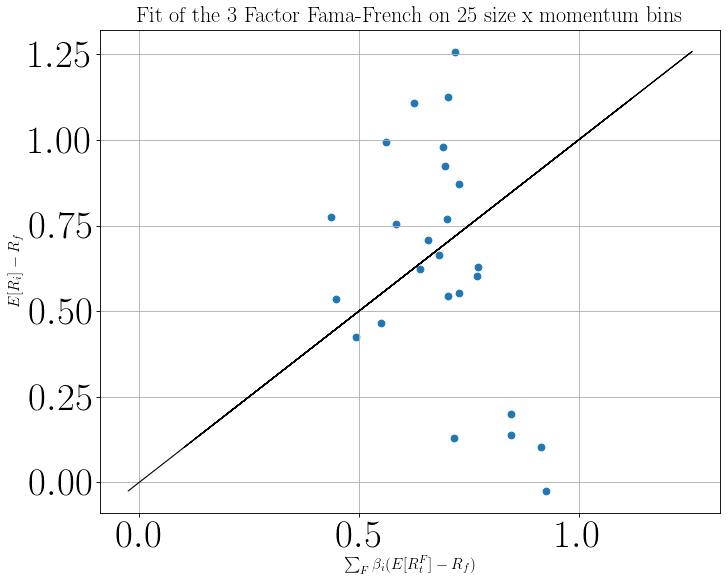

In [190]:
df=data.copy()

rc('text',usetex=True)

for nam in names2Factor:
    df[nam]=df[nam]-df['RF']
df=df[names2Factor]

#def plotMeanFitted(yHat,df):
    # First we need to take averages across all time
    
yHatdf = pd.DataFrame(data = np.matrix(Factorfitted).T)
yHatdf.columns = names2CAPM
yHatMean = yHatdf.mean()
dataMean = df.mean()
fig = plt.figure(figsize=(10, 8), dpi= 80)
ax = fig.gca()
plt.scatter(yHatMean,dataMean)
plt.plot(dataMean,dataMean,color='black',linewidth=1)
ax.grid('false')
ax.set_xlabel(r'$\sum_F \beta_i(E[R_t^F]-R_f$)',fontsize=14)
ax.set_ylabel(r'$E[R_i]-R_f$',fontsize=14)
ax.set_title('Fit of the 3 Factor Fama-French on 25 size x momentum bins',fontsize=20)
plt.show()

 > *For part d) a little more work is needed - we need to get the Sharpe Ratio from the tangency portfolio spanned by all the three factors. Let me write a little function to do this.*

In [191]:
def findMaxSharpe(data, factorList,RFremovedInd):
    if RFremovedInd==False:
        for nam in factorList:
            data[nam]=(data[nam]-data['RF'])

    data=data[factorList]
    
    # start with arbitrary weights
    weights = np.array([1/(len(factorList)) for i in range(len(factorList)-1)])
    # find underlying VCov matrix
    
    VCov=findVCov(data,factorList)
    means = data.mean()

    test =  SharpePort(weights,means,VCov)
    
    res=scipy.optimize.minimize(SharpePort,weights,args=(means,VCov))
    SharpeOpt = res.fun*(-1)
    return SharpeOpt

  
    

In [192]:

# get actual residuals
# Error-Variance Covariacne Matrix
T=resid.shape[1]
Σ = np.matrix((resid@resid.T)/T)

# Next let's get the Sharpe Ratio from the three factors collectively.
toUse = data.copy()
toUse['Mkt-RF'] = toUse['Mkt-RF'] # adding now so that when code subtracts it in function it isn't double counting
SF = findMaxSharpe(toUse, ['Mkt-RF','SMB','HML'],True)

GRSstat = T*(np.matrix(β[:,0])@Σ.I@np.matrix(β[:,0]).T/(1+SF**2)).A1[0]
crit99 = scipy.stats.distributions.chi2.ppf(0.99,Σ.shape[0])
crit95 = scipy.stats.distributions.chi2.ppf(0.95,Σ.shape[0])
print('GRS','    crit99','crit95')
print('{:.0f}'.format(GRSstat),'    {:.0f}'.format(crit99),'     {:.0f}'.format(crit95))

if GRSstat > crit99:
    print('We reject that every α=0 at the 1% level')
elif GRSstat > crit95:
    print('We reject that every α=0 at the 5% level')
else:
    print('We fail to reject that every α=0 at the 5% level')

    

frontierNames = names2Factor+['Mkt-RF','SMB','HML']


toOptimize = data.copy()
for nam in names2Factor:
    toOptimize[nam]=toOptimize[nam]-toOptimize['RF']
toOptimize=toOptimize[frontierNames]

weights = np.array([1/(len(frontierNames)) for i in range(len(frontierNames)-1)])

VCov=findVCov(toOptimize,frontierNames)

means = toOptimize.mean()

temp = SharpePort(weights,means,VCov)
res=scipy.optimize.minimize(SharpePort,weights,args=(means,VCov))
weightsOpt = res.x
weightsOpt=weightsOpt.tolist() +[1-sum(weightsOpt)]

SharpeOpt = res.fun*(-1)
GRS_2 = T*(SharpeOpt**2-SF**2)/(1+SF**2)

print('*******************************************************************************')
print('GRS_2','    crit99','crit95')
print('{:.0f}'.format(GRS_2),'    {:.0f}'.format(crit99),'     {:.0f}'.format(crit95))

if GRS_2 > crit99:
    print('We reject that every α=0 at the 1% level')
elif GRS_2 > crit95:
    print('We reject that every α=0 at the 5% level')
else:
    print('We fail to reject that every α=0 at the 5% level')
if np.abs(GRSstat-GRS_2)>0.1:
    print('The GRS statistics are not the same! Error?!?')
    print('Max Sharpe Ratio should be: {:.4f}'.format(np.sqrt((135*(1+SF**2)+T*SF**2)/T)))
    print('But is calculated as: {:.4f}'.format(SharpeOpt))
    SharpeOpt = np.sqrt((135*(1+SF**2)+T*SF**2)/T)
else:
    print('And both GRS statistics are the same. Praise Providence!')

GRS     crit99 crit95
139     44      38
We reject that every α=0 at the 1% level
*******************************************************************************
GRS_2     crit99 crit95
136     44      38
We reject that every α=0 at the 1% level
The GRS statistics are not the same! Error?!?
Max Sharpe Ratio should be: 0.4825
But is calculated as: 0.4835


> *Again we fail the GRS test calculated both ways and again I must be making an error with one of the tests as I get different test statistics...*
> *let's look at the frontier now*

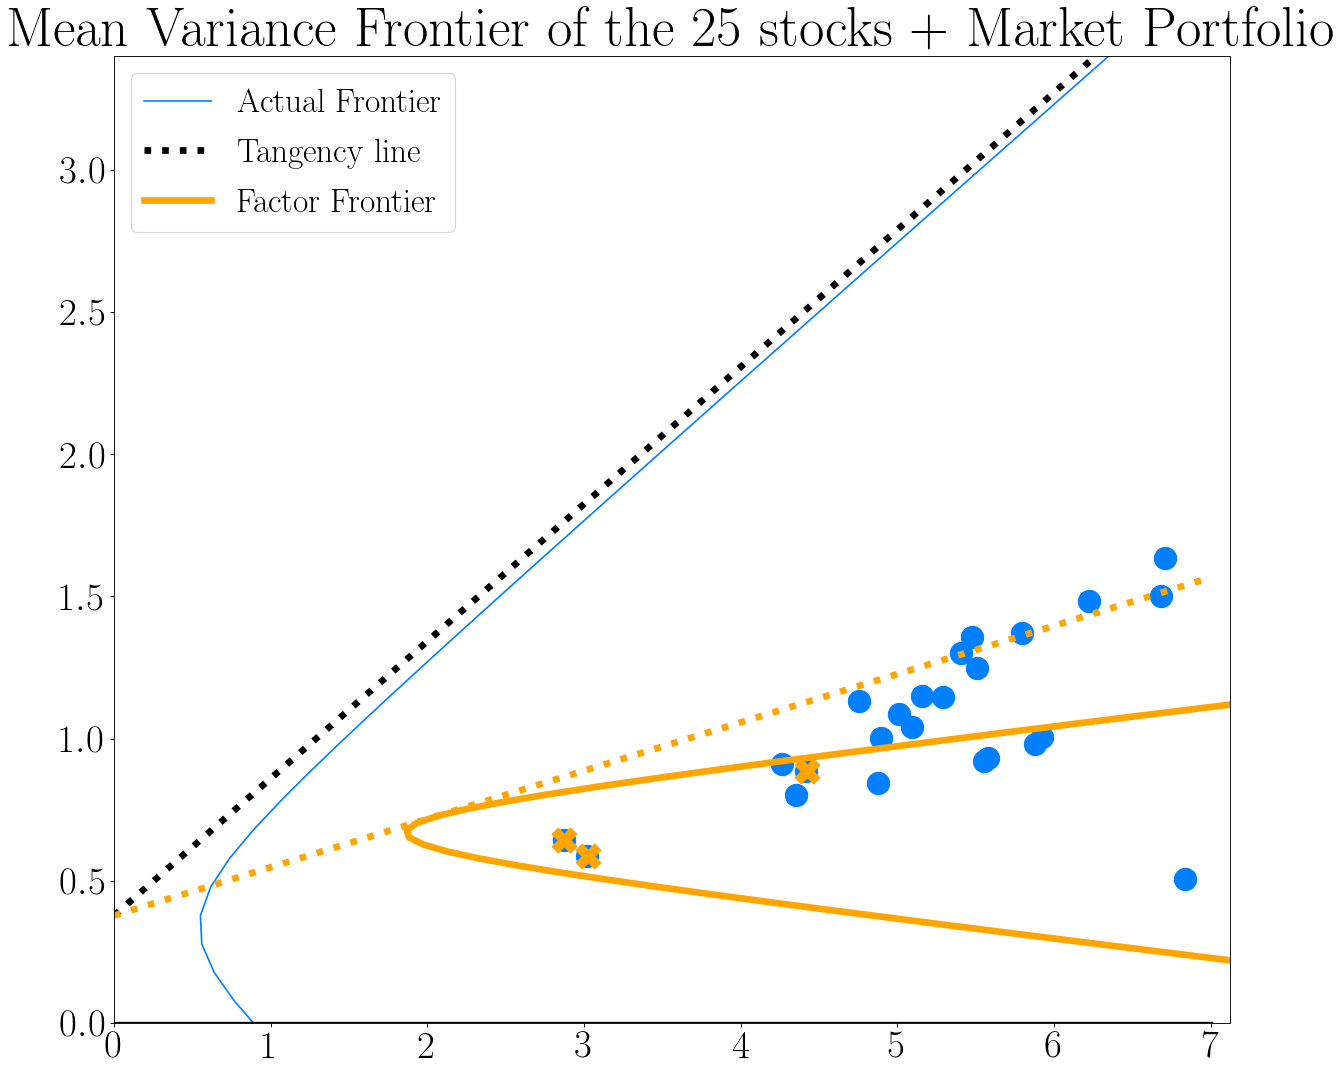

In [193]:

Rf=data['RF'].mean()
meanLimits = np.arange(-0.5,3.5,0.1)
varLimits = findFrontier(meanLimits,frontierNames,VCov,means)

# find meanvar frontier of factors
meanLimits_fac = np.arange(-0.3,4,0.025)
VCov_fac = findVCov(data,['Mkt-RF','SMB','HML'])
means_fac = data[['Mkt-RF','SMB','HML']].mean()
varLimits_fac = findFrontier(meanLimits_fac,['Mkt-RF','SMB','HML'],VCov_fac,means_fac)




res=scipy.optimize.minimize(findTangency,5,args=(SharpeOpt,varLimits,meanLimits))


font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 35}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1,figsize=(18, 16),dpi=80)
    
#plotting   

ax.scatter(np.sqrt(np.diag(VCov)),Rf+means,color=(0,0.5,1),s=400,label='_nolegend_') # portfolios
ax.plot(varLimits,Rf+meanLimits,color=(0,0.5,1))  # frontier
ax.plot([0,round(max(varLimits))],[0,0],color='black',linewidth=3,label='_nolegend_') # zero line
vols = np.arange(0,max(varLimits),0.2)
tmp=ax.plot(vols,Rf+SharpeOpt*vols,color='black',linestyle=':',linewidth=6)
ax.scatter(res.x,Rf+SharpeOpt*res.x,marker='x',color='red',s=1000,linewidth=6)
# Plot market
plt.scatter(data['Mkt-RF'].std(),data['Mkt-RF'].mean()+Rf,marker='X',color='orange',s=500)
plt.scatter(data['HML'].std(),data['HML'].mean()+Rf,marker='X',color='orange',s=500)
plt.scatter(data['SMB'].std(),data['SMB'].mean()+Rf,marker='X',color='orange',s=500)
tmp2=ax.plot(varLimits_fac, Rf+meanLimits_fac,color='orange',linewidth=6)
tmp2=ax.plot(vols, Rf+ SF*vols,color='orange',linestyle=":",linewidth=6)
ax.set_title('Mean Variance Frontier of the 25 stocks + Market Portfolio',fontsize=50)
ax.legend(['Actual Frontier','Tangency line','Factor Frontier'],fontsize=30)
ax.set_xlim([0,np.max(varLimits)])  # set to frontier of the final set of assets
ax.set_ylim([0,np.max(meanLimits)])  # set to frontier of the final set of assets
plt.show()

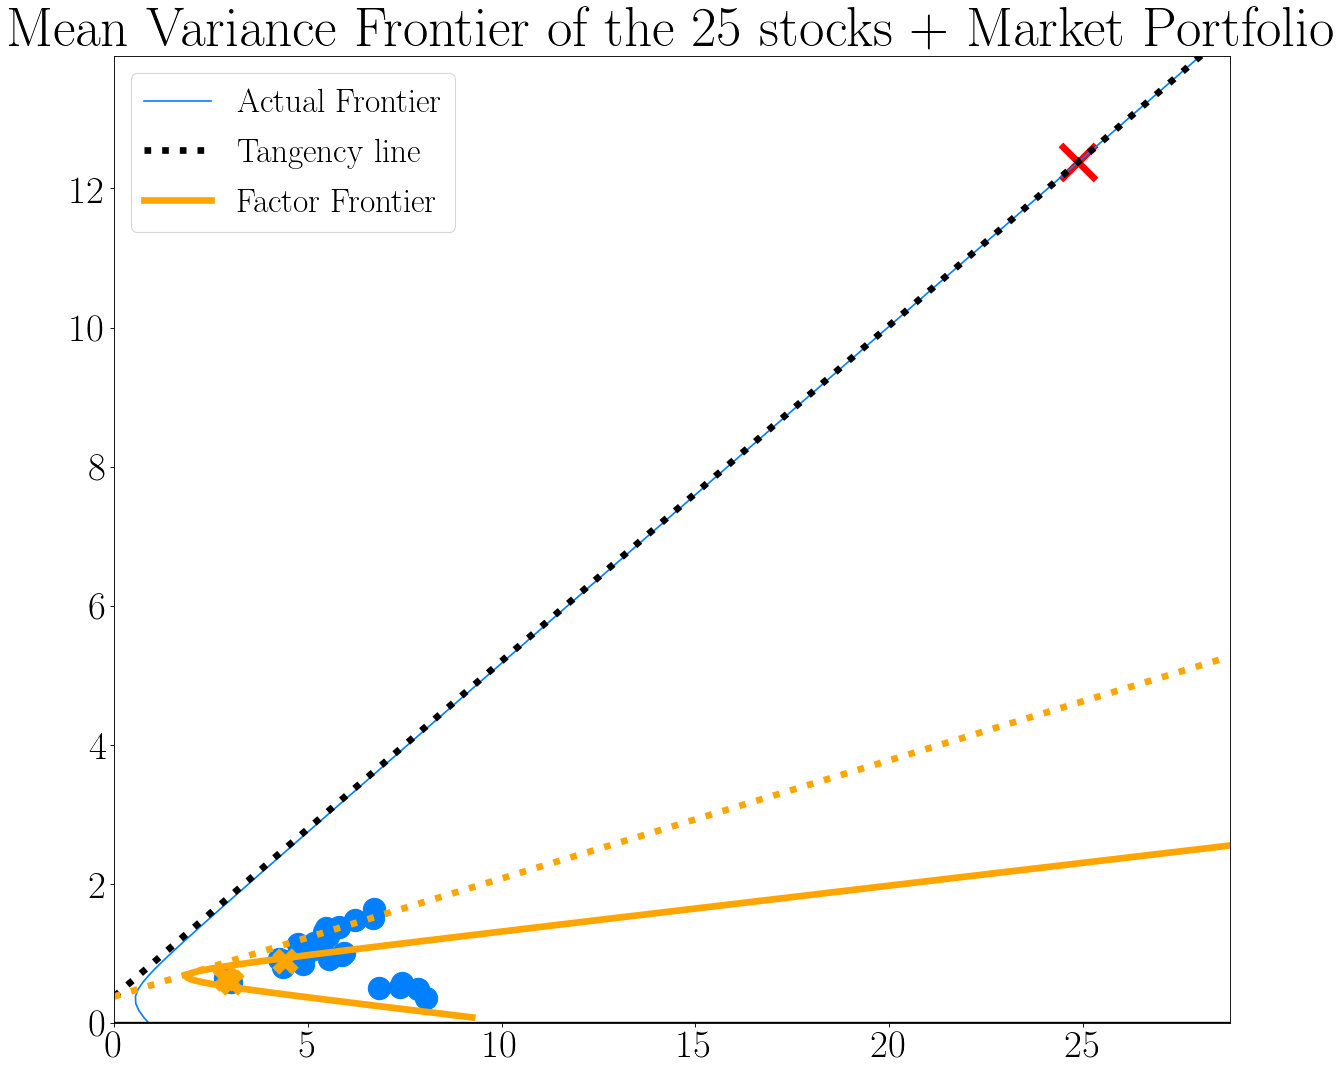

In [194]:

Rf=data['RF'].mean()
meanLimits = np.arange(-0.5,14,0.1)
varLimits = findFrontier(meanLimits,frontierNames,VCov,means)

# find meanvar frontier of factors
meanLimits_fac = np.arange(-0.3,4,0.025)
VCov_fac = findVCov(data,['Mkt-RF','SMB','HML'])
means_fac = data[['Mkt-RF','SMB','HML']].mean()
varLimits_fac = findFrontier(meanLimits_fac,['Mkt-RF','SMB','HML'],VCov_fac,means_fac)




res=scipy.optimize.minimize(findTangency,5,args=(SharpeOpt,varLimits,meanLimits))


font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 35}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1,figsize=(18, 16),dpi=80)
    
#plotting   

ax.scatter(np.sqrt(np.diag(VCov)),Rf+means,color=(0,0.5,1),s=400,label='_nolegend_') # portfolios
ax.plot(varLimits,Rf+meanLimits,color=(0,0.5,1))  # frontier
ax.plot([0,round(max(varLimits))],[0,0],color='black',linewidth=3,label='_nolegend_') # zero line
vols = np.arange(0,max(varLimits),0.2)
tmp=ax.plot(vols,Rf+SharpeOpt*vols,color='black',linestyle=':',linewidth=6)
ax.scatter(res.x,Rf+SharpeOpt*res.x,marker='x',color='red',s=1000,linewidth=6)
# Plot market
plt.scatter(data['Mkt-RF'].std(),data['Mkt-RF'].mean()+Rf,marker='X',color='orange',s=500)
plt.scatter(data['HML'].std(),data['HML'].mean()+Rf,marker='X',color='orange',s=500)
plt.scatter(data['SMB'].std(),data['SMB'].mean()+Rf,marker='X',color='orange',s=500)
tmp2=ax.plot(varLimits_fac, Rf+meanLimits_fac,color='orange',linewidth=6)
tmp2=ax.plot(vols, Rf+ SF*vols,color='orange',linestyle=":",linewidth=6)
ax.set_title('Mean Variance Frontier of the 25 stocks + Market Portfolio',fontsize=50)
ax.legend(['Actual Frontier','Tangency line','Factor Frontier'],fontsize=30)
ax.set_xlim([0,np.max(varLimits)])  # set to frontier of the final set of assets
ax.set_ylim([0,np.max(meanLimits)])  # set to frontier of the final set of assets
plt.show()

> *Based on this graph it looks like there is a big difference between the frontier spanned by the yellow and the frontier spanned by the blue. The 3 factor model is also rejected!* 

# Question 3

In [202]:


# Check merge carefully
data_=data.copy()
checkMerge = False
if checkMerge==True:
    data = pd.merge(MoM,data_,on="Date",how='outer',indicator=True)
    print(data.groupby('_merge').count())
else:
    data = pd.merge(MoM,data_,on="Date",how='inner')


names2Factor = [item for item in  data.columns.values.tolist() if item not in ['SMB','HML','RMW','CMA','RF','Mkt-RF','Date','MoM']]
##################### Regression time!####################################
β,se,seWhite,seNW,Factorfitted,resid = CAPMregressions(data, names2Factor,['Mkt-RF','SMB','HML','MoM'],True,True)


######################Nice Table Output##################################
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=1,thresh=1,varNam='β Mkt-RF',showT=False)
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=2,thresh=1,varNam='β SMB',showT=False)
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=3,thresh=1,varNam='β HML',showT=False)
niceOutput_β,tStat_β=niceOutput(β,se,seWhite,seNW,col2extract=4,thresh=1,varNam='β MoM',showT=False)

Results for β Mkt-RF


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,1.050**,0.878***,0.866***,0.879***,1.036*
(se),"(0.022,0.026,0.024)","(0.014,0.018,0.021)","(0.014,0.017,0.019)","(0.014,0.018,0.020)","(0.018,0.024,0.019)"
ME2,1.170***,0.976*,0.938***,0.961**,1.146***
(se),"(0.017,0.018,0.023)","(0.014,0.015,0.014)","(0.013,0.016,0.018)","(0.012,0.014,0.016)","(0.014,0.021,0.022)"
ME3,1.150***,1.008,0.960**,0.989,1.126***
(se),"(0.020,0.027,0.035)","(0.014,0.019,0.018)","(0.014,0.016,0.016)","(0.014,0.020,0.019)","(0.015,0.015,0.018)"
ME4,1.195***,1.060***,0.999,1.007,1.114***
(se),"(0.023,0.035,0.039)","(0.016,0.020,0.021)","(0.015,0.020,0.021)","(0.015,0.018,0.018)","(0.016,0.019,0.022)"
Big,1.168***,0.938***,0.950***,0.970,1.079***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)
Results for β SMB


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,1.242***,0.975,0.904,0.922*,1.155***
(se),"(0.031,0.045,0.043)","(0.020,0.038,0.051)","(0.020,0.041,0.061)","(0.020,0.032,0.042)","(0.025,0.051,0.038)"
ME2,0.955,0.779***,0.694***,0.766***,0.963
(se),"(0.023,0.031,0.032)","(0.019,0.033,0.049)","(0.018,0.031,0.053)","(0.017,0.029,0.049)","(0.020,0.034,0.029)"
ME3,0.621***,0.482***,0.471***,0.454***,0.723***
(se),"(0.028,0.042,0.038)","(0.020,0.037,0.054)","(0.019,0.032,0.050)","(0.020,0.041,0.071)","(0.020,0.025,0.031)"
ME4,0.333***,0.187***,0.182***,0.173***,0.444***
(se),"(0.032,0.042,0.037)","(0.022,0.036,0.053)","(0.021,0.039,0.067)","(0.021,0.046,0.071)","(0.023,0.030,0.027)"
Big,-0.107***,-0.189***,-0.199***,-0.218***,-0.027***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)
Results for β HML


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.002***,0.274***,0.316***,0.262***,0.033***
(se),"(0.034,0.056,0.064)","(0.021,0.032,0.042)","(0.022,0.029,0.041)","(0.021,0.034,0.043)","(0.027,0.043,0.042)"
ME2,-0.069***,0.200***,0.263***,0.254***,-0.033***
(se),"(0.025,0.031,0.033)","(0.020,0.028,0.051)","(0.020,0.028,0.054)","(0.018,0.025,0.041)","(0.022,0.036,0.038)"
ME3,-0.058***,0.204***,0.274***,0.307***,-0.061***
(se),"(0.030,0.044,0.048)","(0.021,0.033,0.058)","(0.021,0.030,0.060)","(0.021,0.035,0.066)","(0.022,0.026,0.028)"
ME4,0.049***,0.197***,0.259***,0.205***,-0.039***
(se),"(0.034,0.058,0.064)","(0.023,0.035,0.073)","(0.022,0.036,0.079)","(0.022,0.036,0.075)","(0.024,0.034,0.029)"
Big,-0.003***,0.112***,0.124***,0.130***,-0.051***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)
Results for β MoM


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.696***,-0.248***,-0.084***,0.085***,0.290***
(se),"(0.023,0.059,0.065)","(0.014,0.023,0.030)","(0.015,0.025,0.035)","(0.014,0.027,0.037)","(0.018,0.036,0.034)"
ME2,-0.720***,-0.310***,-0.057***,0.091***,0.355***
(se),"(0.017,0.044,0.059)","(0.014,0.027,0.033)","(0.013,0.020,0.032)","(0.012,0.020,0.031)","(0.015,0.023,0.023)"
ME3,-0.769***,-0.325***,-0.129***,0.105***,0.407***
(se),"(0.020,0.026,0.034)","(0.014,0.018,0.025)","(0.014,0.023,0.034)","(0.014,0.030,0.040)","(0.015,0.020,0.024)"
ME4,-0.809***,-0.381***,-0.137***,0.088***,0.441***
(se),"(0.023,0.034,0.040)","(0.016,0.028,0.038)","(0.015,0.022,0.038)","(0.015,0.024,0.038)","(0.016,0.022,0.021)"
Big,-0.764***,-0.428***,-0.098***,0.169***,0.469***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 1 at the 1% level (using NW)
** = significantly different from 1 at the 5% level (using NW)
* = significantly different from 1 at the 10% level (using NW)


In [203]:
niceOutput_α,tStat_α=niceOutput(β,se,seWhite,seNW,col2extract=0,thresh=0,varNam='α',showT=True)

Results for α


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.353***,0.046,0.216***,0.217***,0.292***
(t-Stat),"(-3.741,-3.012,-3.279)","(0.758,0.757,0.768)","(3.538,3.638,3.353)","(3.619,3.362,2.940)","(3.855,3.544,3.033)"
ME2,-0.194*,0.124**,0.116**,0.148**,0.117*
(t-Stat),"(-2.772,-2.438,-1.940)","(2.175,2.073,2.185)","(2.115,2.052,1.977)","(2.873,2.718,2.570)","(1.939,1.818,1.685)"
ME3,0.014,0.104*,0.093,-0.039,0.132**
(t-Stat),"(0.164,0.154,0.157)","(1.763,1.754,1.662)","(1.596,1.561,1.397)","(-0.648,-0.606,-0.646)","(2.159,2.202,2.055)"
ME4,-0.014,0.169***,0.100,0.095,0.055
(t-Stat),"(-0.149,-0.129,-0.132)","(2.574,2.416,2.722)","(1.627,1.572,1.383)","(1.526,1.544,1.557)","(0.801,0.774,0.802)"
Big,0.067,0.282***,0.016,-0.059,-0.065


t-Statistics are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using NW)
** = significantly different from 0 at the 5% level (using NW)
* = significantly different from 0 at the 10% level (using NW)


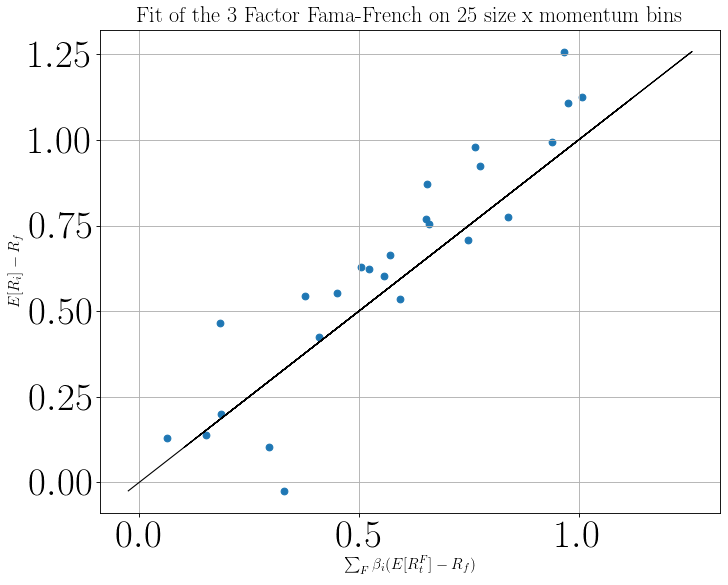

In [163]:
df=data.copy()

rc('text',usetex=True)

for nam in names2Factor:
    df[nam]=df[nam]-df['RF']
df=df[names2Factor]

#def plotMeanFitted(yHat,df):
    # First we need to take averages across all time
    
yHatdf = pd.DataFrame(data = np.matrix(Factorfitted).T)
yHatdf.columns = names2CAPM
yHatMean = yHatdf.mean()
dataMean = df.mean()
fig = plt.figure(figsize=(10, 8), dpi= 80)
ax = fig.gca()
plt.scatter(yHatMean,dataMean)
plt.plot(dataMean,dataMean,color='black',linewidth=1)
ax.grid('false')
ax.set_xlabel(r'$\sum_F \beta_i(E[R_t^F]-R_f$)',fontsize=14)
ax.set_ylabel(r'$E[R_i]-R_f$',fontsize=14)
ax.set_title('Fit of the 3 Factor Fama-French on 25 size x momentum bins',fontsize=20)
plt.show()

> *This is the closes we have seen to the factor model/CAPM lines fitting well. It is by no means a perfect fit but its not too bad!*

In [164]:

# get actual residuals
# Error-Variance Covariacne Matrix
T=resid.shape[1]
Σ = np.matrix((resid@resid.T)/T)

# Next let's get the Sharpe Ratio from the three factors collectively.
toUse = data.copy()
toUse['Mkt-RF'] = toUse['Mkt-RF'] # adding now so that when code subtracts it in function it isn't double counting
SF = findMaxSharpe(toUse, ['Mkt-RF','SMB','HML','MoM'],True)

GRSstat = T*(np.matrix(β[:,0])@Σ.I@np.matrix(β[:,0]).T/(1+SF**2)).A1[0]
crit99 = scipy.stats.distributions.chi2.ppf(0.99,Σ.shape[0])
crit95 = scipy.stats.distributions.chi2.ppf(0.95,Σ.shape[0])
print('GRS','    crit99','crit95')
print('{:.0f}'.format(GRSstat),'    {:.0f}'.format(crit99),'     {:.0f}'.format(crit95))

if GRSstat > crit99:
    print('We reject that every α=0 at the 1% level')
elif GRSstat > crit95:
    print('We reject that every α=0 at the 5% level')
else:
    print('We fail to reject that every α=0 at the 5% level')

    

frontierNames = names2Factor+['Mkt-RF','SMB','HML','MoM']


toOptimize = data.copy()
for nam in names2Factor:
    toOptimize[nam]=toOptimize[nam]-toOptimize['RF']
toOptimize=toOptimize[frontierNames]

weights = np.array([1/(len(frontierNames)) for i in range(len(frontierNames)-1)])

VCov=findVCov(toOptimize,frontierNames)

means = toOptimize.mean()

temp = SharpePort(weights,means,VCov)
res=scipy.optimize.minimize(SharpePort,weights,args=(means,VCov))
weightsOpt = res.x
weightsOpt=weightsOpt.tolist() +[1-sum(weightsOpt)]

SharpeOpt = res.fun*(-1)
GRS_2 = T*(SharpeOpt**2-SF**2)/(1+SF**2)

print('*******************************************************************************')
print('GRS_2','    crit99','crit95')
print('{:.0f}'.format(GRS_2),'    {:.0f}'.format(crit99),'     {:.0f}'.format(crit95))

if GRS_2 > crit99:
    print('We reject that every α=0 at the 1% level')
elif GRS_2 > crit95:
    print('We reject that every α=0 at the 5% level')
else:
    print('We fail to reject that every α=0 at the 5% level')
if np.abs(GRSstat-GRS_2)>0.1:
    print('The GRS statistics are not the same! Error?!?')
    print('Max Sharpe Ratio should be: {:.4f}'.format(np.sqrt((135*(1+SF**2)+T*SF**2)/T)))
    print('But is calculated as: {:.4f}'.format(SharpeOpt))
else:
    print('And both GRS statistics are the same. Praise Providence!')

GRS     crit99 crit95
105     44      38
We reject that every α=0 at the 1% level
*******************************************************************************
GRS_2     crit99 crit95
99     44      38
We reject that every α=0 at the 1% level
The GRS statistics are not the same! Error?!?
Max Sharpe Ratio should be: 0.5363
But is calculated as: 0.4804


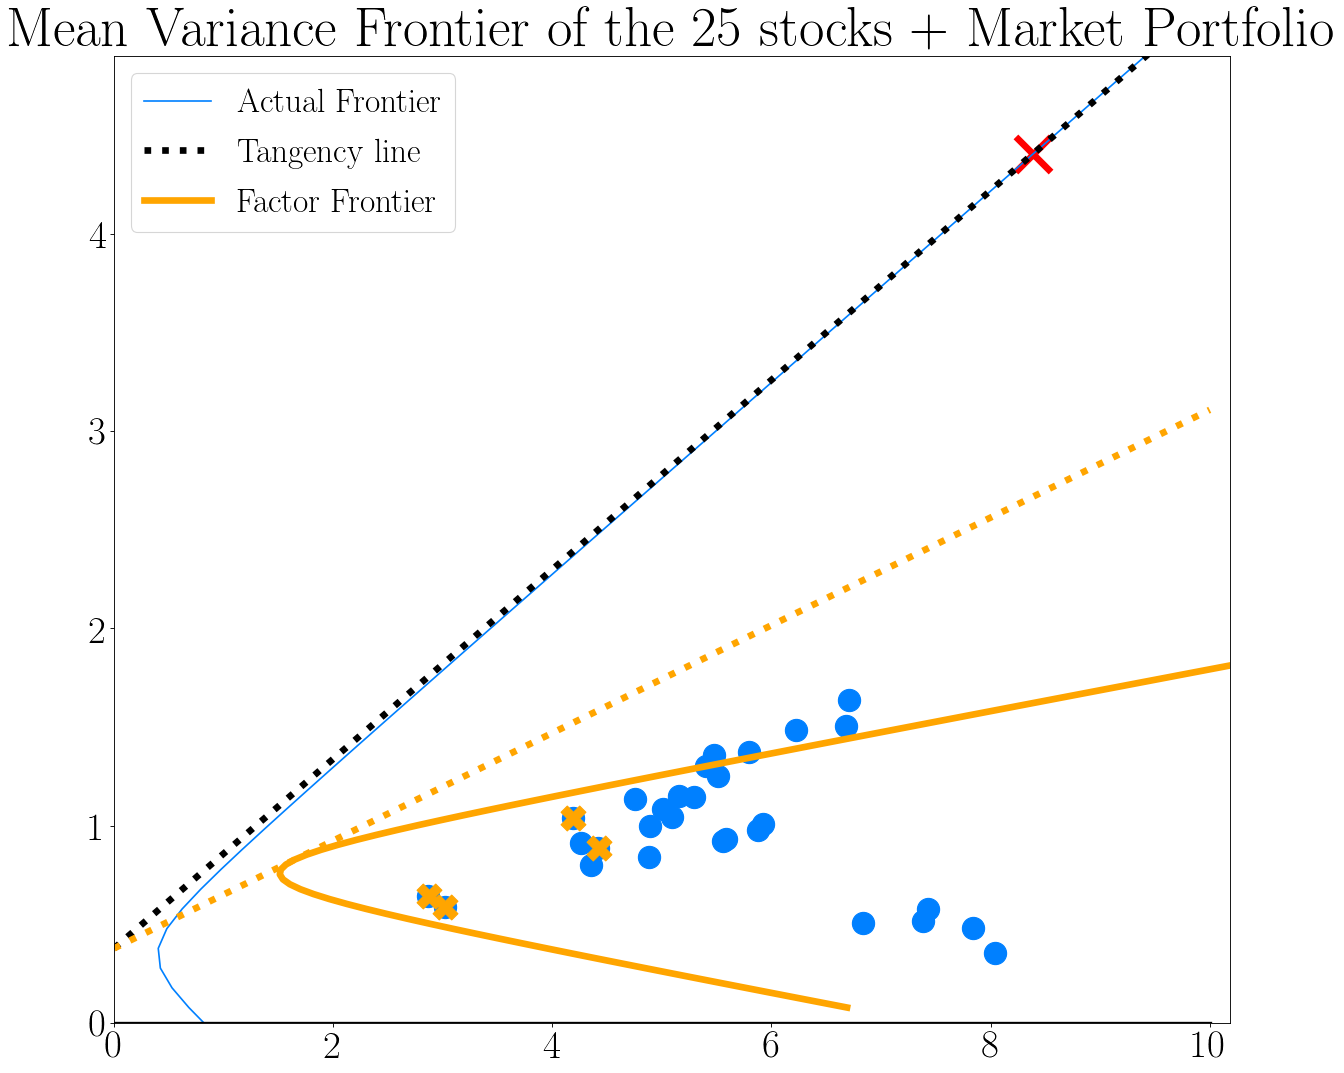

In [165]:

Rf=data['RF'].mean()
meanLimits = np.arange(-0.5,5,0.1)
varLimits = findFrontier(meanLimits,frontierNames,VCov,means)

# find meanvar frontier of factors
meanLimits_fac = np.arange(-0.3,2,0.025)
VCov_fac = findVCov(data,['Mkt-RF','SMB','HML','MoM'])
means_fac = data[['Mkt-RF','SMB','HML','MoM']].mean()
varLimits_fac = findFrontier(meanLimits_fac,['Mkt-RF','SMB','HML','MoM'],VCov_fac,means_fac)




res=scipy.optimize.minimize(findTangency,5,args=(SharpeOpt,varLimits,meanLimits))


font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 35}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1,figsize=(18, 16),dpi=80)
    
#plotting   

ax.scatter(np.sqrt(np.diag(VCov)),Rf+means,color=(0,0.5,1),s=400,label='_nolegend_') # portfolios
ax.plot(varLimits,Rf+meanLimits,color=(0,0.5,1))  # frontier
ax.plot([0,round(max(varLimits))],[0,0],color='black',linewidth=3,label='_nolegend_') # zero line
vols = np.arange(0,max(varLimits),0.2)
tmp=ax.plot(vols,Rf+SharpeOpt*vols,color='black',linestyle=':',linewidth=6)
ax.scatter(res.x,Rf+SharpeOpt*res.x,marker='x',color='red',s=1000,linewidth=6)
# Plot market
plt.scatter(data['Mkt-RF'].std(),data['Mkt-RF'].mean()+Rf,marker='X',color='orange',s=500)
plt.scatter(data['HML'].std(),data['HML'].mean()+Rf,marker='X',color='orange',s=500)
plt.scatter(data['SMB'].std(),data['SMB'].mean()+Rf,marker='X',color='orange',s=500)
plt.scatter(data['MoM'].std(),data['MoM'].mean()+Rf,marker='X',color='orange',s=500)
tmp2=ax.plot(varLimits_fac, Rf+meanLimits_fac,color='orange',linewidth=6)
tmp2=ax.plot(vols, Rf+ SF*vols,color='orange',linestyle=":",linewidth=6)
ax.set_title('Mean Variance Frontier of the 25 stocks + Market Portfolio',fontsize=50)
ax.legend(['Actual Frontier','Tangency line','Factor Frontier'],fontsize=30)
ax.set_xlim([0,np.max(varLimits)])  # set to frontier of the final set of assets
ax.set_ylim([0,np.max(meanLimits)])  # set to frontier of the final set of assets
plt.show()

> *Despite our Yhat vs Y line fititng better than we have seen up until now, on this graph it is clear that we are missing a lot. Test of MV efficiency rejected! You can also see the GRS tests are still heavily rejected. Tut Tut Factor model!
*

# Question 4

> *And now for something completely different*

(a) Estimate the risk premia of the 4-factor Fama-French-Carhart model model using a crosssectional
regression. Compute the standard errors of the factor premia assuming that the
beta’s in the first stage are known. Summarize the regression results.

In [238]:
def niceOutput_CS(β,ses_fancy,thresh,varNam,showT,rowNames_init):
    β=β[0]
   
    
    colNames = [varNam]
    
    rowNames=[]
    for r in rowNames_init:
        if showT==False:
            rowNames = rowNames+[r,'(s.e.)']
        else:
            rowNames = rowNames+[r,'(t-Stat)']

    output_β = pd.DataFrame(columns = colNames,index=rowNames)
    output_β=output_β.reset_index()

    tStat = (β-thresh)/ses_fancy
    
    countb=0
    for w in range(len(colNames)):
        for h in range(np.round(len(rowNames)/2).astype('int')):
            if abs(tStat[countb])> scipy.stats.norm.ppf(0.995):
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])+'***'
            elif abs(tStat[countb])> scipy.stats.norm.ppf(0.975):
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])+'**'
            elif abs(tStat[countb])> scipy.stats.norm.ppf(0.95):
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])+'*'
            else:
                output_β.loc[2*h,colNames[w]] = '{:.3f}'.format(β[countb])
            if showT==False:
                output_β.loc[2*h+1,colNames[w]] = '('+'{:.3f}'.format(ses_fancy[countb])+')'
            else:
                output_β.loc[2*h+1,colNames[w]] = '('+'{:.3f}'.format(tStat[countb])+')'


            countb+=1
    output_β=output_β.set_index('index')
    print("Results for "+varNam)
    display(HTML(output_β.to_html()))
    if showT==False:
        print('Standard errors are in the form (homoskedastic, White, Newey West(12))')
    else:
        print('t-Statistics are in the form (homoskedastic, White, Newey West(12))')
    print('*** = significantly different from '+str(thresh)+' at the 1% level (using White)')
    print('** = significantly different from '+str(thresh)+' at the 5% level (using White)')
    print('* = significantly different from '+str(thresh)+' at the 10% level (using White)')
    
    # calculate R^2 and print
    Y=np.matrix(CS_data['ExcessReturns_i'].values).T
    R2 = (Y.T@Y- np.matrix(resid_ER)@np.matrix(resid_ER).T)/(Y.T@Y)
    print('R^2 is: {:.3f}'.format(R2.A1[0]))

    return output_β,tStat

def FancySes(β,λ,resid,data,factorNames):
    # get factor variance
    factors = np.matrix(data[factorNames].values)
    T = np.shape(factors)[0]
    Σ_F = factors.T@factors/T
    
    #get CS regression residuals
    ϵ = np.matrix(resid)
    Σ = ϵ.T@ϵ/T
    
    β=np.matrix(β)
    λ = np.matrix(λ)
    
    scaleFac = (1+λ@Σ_F@λ.T)
    
    
    Cov_hatλ = 1/T*((β.T@β).I@(β.T@Σ@β)@(β.T@β).I*scaleFac.A1[0]+Σ_F)
    
    ses_fancy = np.sqrt(np.diag(Cov_hatλ))
    return ses_fancy

In [239]:
ExcessReturns_i = data[names2Factor].mean()

CS_data = pd.DataFrame(ExcessReturns_i)-Rf  # factor means have Rf in them
CS_data.columns=['ExcessReturns_i']

β_i = β[:,1:]  # first column of β is actually α! see the regression code above 
CS_data['Mkt-RF'] = β_i[:,0]
CS_data['SMB'] = β_i[:,1]
CS_data['HML'] = β_i[:,2]
CS_data['MoM'] = β_i[:,3]


λ,se,seWhite,seNW,ER_fitted,resid_ER = CAPMregressions(CS_data, ['ExcessReturns_i'],['Mkt-RF','SMB','HML','MoM'],True,False)

# Standard Errors with Shanken Correction
ses_fancy = FancySes(β_i,λ[:,1:],resid_ER,data,['Mkt-RF','SMB','HML','MoM'])
# append the alpha s.e.
ses_fancy = seWhite.tolist() + ses_fancy.tolist()
# produce nice output!
print('**************************************************************************')
print('REGRESSION WITH CONSTANT')
λ_nice, tStat_nice=niceOutput_CS(λ,np.array(ses_fancy[0]),0,'λ',False,['Constant','Mkt-RF','SMB','HML','MoM'])

λ_2,se,seWhite,seNW,ER_fitted,resid_ER2 = CAPMregressions(CS_data, ['ExcessReturns_i'],['Mkt-RF','SMB','HML','MoM'],False,False)

# Standard Errors with Shanken Correction
ses_fancy = FancySes(β_i,λ_2,resid_ER2,data,['Mkt-RF','SMB','HML','MoM'])
# produce nice output!
print('**************************************************************************')
print('REGRESSION WITHOUT CONSTANT')
λ_nice, tStat_nice=niceOutput_CS(λ_2,np.array(ses_fancy),0,'λ',False,['Mkt-RF','SMB','HML','MoM'])


**************************************************************************
REGRESSION WITH CONSTANT
Results for λ


,λ
index,
Constant,0.094
(s.e.),(0.777)
Mkt-RF,0.463
(s.e.),(0.690)
SMB,0.189**
(s.e.),(0.088)
HML,0.600
(s.e.),(0.510)
MoM,0.768***


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using White)
** = significantly different from 0 at the 5% level (using White)
* = significantly different from 0 at the 10% level (using White)
R^2 is: 0.972
**************************************************************************
REGRESSION WITHOUT CONSTANT
Results for λ


,λ
index,
Mkt-RF,0.548***
(s.e.),(0.170)
SMB,0.191
(s.e.),(0.116)
HML,0.651***
(s.e.),(0.110)
MoM,0.772***
(s.e.),(0.162)


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using White)
** = significantly different from 0 at the 5% level (using White)
* = significantly different from 0 at the 10% level (using White)
R^2 is: 0.972


> *Cool! I added a constant even though I didn't need to and it is insignificant from 0! This is consistent with the factor model being mean-variance effecient but is not enough evidence for this to be our conclusion yet. For that we need to show that the residuals are zero! Next see that the R^2 is extremely high -- also a sign that this portfolio is MV efficient since we want the resituals to be 0. So let's conduct a official test. Note also this is a cross-sectional model so using NW standard errors is inappropriate.*

(b) Compare the estimated risk premia of the four factors to the risk premia implied by the
model.

> *Factor premia are just the average returns we observe for each factor in the data (since each is already an excess return. Let's calculate and compare. The point of the cross-sectional regression is if the factors are MV efficient, then we should be able to infer these expected returns using only the $\lambda_i$s -- the differences in expected returns of our 25 portoflios we can attribute to each factor's $\beta$.*

In [240]:
rowNames =['Mkt-RF','SMB','HML','MoM'] 
nice_df = pd.DataFrame(index=rowNames)
nice_df['λ - w constant'] = np.matrix(λ[0,1:]).T
nice_df['λ - no constant'] = np.matrix(λ_2).T
nice_df['Factor Premia'] = np.nan
nice_df.loc['Mkt-RF','Factor Premia'] = data['Mkt-RF'].mean()
nice_df.loc['SMB','Factor Premia'] = data['SMB'].mean()
nice_df.loc['HML','Factor Premia'] = data['HML'].mean()
nice_df.loc['MoM','Factor Premia'] = data['MoM'].mean()

nice_df


,λ - w constant,λ - no constant,Factor Premia
Mkt-RF,0.463496,0.548335,0.507166
SMB,0.189473,0.190811,0.207841
HML,0.600181,0.651040,0.266960
MoM,0.768280,0.771827,0.663421


> *As can be seen the risk premia here estimated from the $\lambda$s are actually quite similar to the expected returns -- cool!  You might be wondering that there keeps being another thing to keep checking to be sure these models are "correct" or fitting the data well -- that's right. MV efficiency of factors imposes a lot of restrictions on how each factor should fit the data. There ends up being a lot to test and a lot to reject. Note that if we do include a constant the fit is a lot better but again, we shouldn't need the constant in the regression.* 

(c) Compare the pricing errors from the time-series regressions in question 3 to the pricing errors
of the cross-sectional regression.

In [241]:
A=np.array((λ[0]+resid_ER.T,λ[0]+resid_ER.T)).T[0]


# These are residuals so have no standard errors but let me be lazy and run this function to get some nice output
A,B=niceOutput(A,np.inf*A,np.inf*A,np.inf*A,col2extract=0,thresh=0,varNam='α_i with a constant',showT=False)
A=np.array((resid_ER2.T,resid_ER2.T)).T[0]
A,B=niceOutput(A,np.inf*A,np.inf*A,np.inf*A,col2extract=0,thresh=0,varNam='α_i without a constant',showT=False)



Results for α_i with a constant


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.211,0.036,0.174,0.176,0.317
(se),"(-inf,-inf,-inf)","(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)"
ME2,-0.027,0.147,0.088,0.110,0.159
(se),"(-inf,-inf,-inf)","(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)"
ME3,0.175,0.123,0.066,-0.101,0.172
(se),"(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)","(-inf,-inf,-inf)","(inf,inf,inf)"
ME4,0.113,0.193,0.075,0.065,0.078
(se),"(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)"
Big,0.197,0.326,0.023,-0.081,-0.050


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using NW)
** = significantly different from 0 at the 5% level (using NW)
* = significantly different from 0 at the 10% level (using NW)
Results for α_i without a constant


,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.299,-0.052,0.083,0.087,0.224
(se),"(-inf,-inf,-inf)","(-inf,-inf,-inf)","(inf,inf,inf)","(inf,inf,inf)","(inf,inf,inf)"
ME2,-0.121,0.054,-0.006,0.014,0.061
(se),"(-inf,-inf,-inf)","(inf,inf,inf)","(-inf,-inf,-inf)","(inf,inf,inf)","(inf,inf,inf)"
ME3,0.083,0.028,-0.030,-0.201,0.077
(se),"(inf,inf,inf)","(inf,inf,inf)","(-inf,-inf,-inf)","(-inf,-inf,-inf)","(inf,inf,inf)"
ME4,0.011,0.094,-0.022,-0.032,-0.016
(se),"(inf,inf,inf)","(inf,inf,inf)","(-inf,-inf,-inf)","(-inf,-inf,-inf)","(-inf,-inf,-inf)"
Big,0.101,0.243,-0.063,-0.171,-0.141


Standard errors are in the form (homoskedastic, White, Newey West(12))
*** = significantly different from 0 at the 1% level (using NW)
** = significantly different from 0 at the 5% level (using NW)
* = significantly different from 0 at the 10% level (using NW)


In [242]:
niceOutput_α

,LowPrior,Prior2,Prior3,Prior4,Prior5
index,,,,,
Small,-0.353***,0.046,0.216***,0.217***,0.292***
(t-Stat),"(-3.741,-3.012,-3.279)","(0.758,0.757,0.768)","(3.538,3.638,3.353)","(3.619,3.362,2.940)","(3.855,3.544,3.033)"
ME2,-0.194*,0.124**,0.116**,0.148**,0.117*
(t-Stat),"(-2.772,-2.438,-1.940)","(2.175,2.073,2.185)","(2.115,2.052,1.977)","(2.873,2.718,2.570)","(1.939,1.818,1.685)"
ME3,0.014,0.104*,0.093,-0.039,0.132**
(t-Stat),"(0.164,0.154,0.157)","(1.763,1.754,1.662)","(1.596,1.561,1.397)","(-0.648,-0.606,-0.646)","(2.159,2.202,2.055)"
ME4,-0.014,0.169***,0.100,0.095,0.055
(t-Stat),"(-0.149,-0.129,-0.132)","(2.574,2.416,2.722)","(1.627,1.572,1.383)","(1.526,1.544,1.557)","(0.801,0.774,0.802)"
Big,0.067,0.282***,0.016,-0.059,-0.065


> *They are not the same at all when comparing the $\alpha$s estimated without a constant! Why is this? The reason is that if across the portfolio bins, $\alpha_i$ and $\beta_i$ are correlated, then the estimation of $\lambda_{factor}$ won't equal $E[R_{factor}-R^f]$. To see why imagine for this factor, that high beta stocks also have a high alpha. When running the cross-sectional regression, excess returns will rise with $\beta$ for two reasons:*
> 1. *Becuase $\beta$ is rising and*
> 2. *Because the pricing errors are also rising with $\beta$.
>
> *Estimating $\lambda$ with OLS will pick up both! Note that with a constant the estimates are typically now much more similar. So that is reassuring but still doesn't mean the model is working*

In [248]:
from ipywidgets import IntProgress
from IPython.display import display
def getRollingOutput(data,Ylist,factorList,SampleSize):
    
    α_TS = pd.DataFrame(index=range(0,np.shape(data)[0]-SampleSize),columns =Ylist)
    α_se_TS = α_TS.copy()
    
    # Store β data in long format. Each row will correspond to a portfolio in Ylist and a time period t
    β = pd.DataFrame(index=range(0,(np.shape(data)[0]-SampleSize)*len(Ylist)),columns = factorList)
    Ylist_rep = [y for t in range(np.shape(data)[0]-SampleSize) for y in Ylist]
    tlist_rep = [t for t in range(np.shape(data)[0]-SampleSize) for y in Ylist]
    β['Ylist'] =Ylist_rep
    β['time'] = tlist_rep
    seNW = β.copy()
    
    # go back to time on vertical and ylist on horizontal
    ER = pd.DataFrame(index=range(0,np.shape(data)[0]-SampleSize),columns =factorList)
    c =  pd.DataFrame(index=range(0,np.shape(data)[0]-SampleSize),columns =['constant'])
    c_se = c.copy()
    
    λ =  ER.copy()
    λ_se = λ.copy()
    α_CS =α_TS.copy()  # no s.e.s for α in the cross sectional regressions
    
    f = IntProgress(min=0, max=(np.shape(data)[0]-SampleSize)) # instantiate the bar
    display(f)
    
    #Loop and then truncate sample!
    for T in range(SampleSize,np.shape(data)[0]):
        # truncate data
        dt = data.loc[data.index[T-SampleSize:T]]
        
        # estimate the time series betas and expected returns   
        β_t,_,_,seNW_t,fitted_CS,resid_TS = CAPMregressions(dt, Ylist,factorList,addconstant = True,removeRf = False)
        
        # Save them down!
        α_TS.loc[T-SampleSize,Ylist] = β_t[:,0]
        α_se_TS.loc[T-SampleSize,Ylist] = seNW_t[:,0]
        
        β.loc[β['time'] == (T-SampleSize),factorList] = β_t[:,1:]
        seNW.loc[seNW['time']==(T-SampleSize),factorList] = seNW_t[:,1:]
        
        ER.loc[T-SampleSize,factorList] = dt[factorList].mean()-data['RF'].mean()
        
        CS_data = pd.DataFrame(index=Ylist,data=β_t[:,1:])
        CS_data.columns = factorList
        CS_data['ExcessReturns_i']= dt[Ylist].mean()
        
        # run Cross-Sectional Regression
        λ_cs,_,se,_,fitted_CS,resid_CS = CAPMregressions(CS_data, ['ExcessReturns_i'],factorList,True,False)
        ses_fancy = FancySes(β_t[:,1:],λ_cs[:,1:],resid_CS,dt,factorList)
        α_CS.loc[T-SampleSize,Ylist] = resid_CS
        
        c.loc[T-SampleSize,'constant'] = λ_cs[0][0]
        c_se.loc[T-SampleSize,'constant'] = se[0][0]
       
        λ.loc[T-SampleSize,factorList] = λ_cs[:,1:]
        λ_se.loc[T-SampleSize,factorList] = ses_fancy
        f.value+=1
        
    return α_TS,α_se_TS,β,seNW,λ,λ_se,α_CS,c,c_se,ER

In [249]:
α_TS,α_TS_se,β,β_se_NW,λ,λ_se,α_CS,c,c_se,ER=getRollingOutput(data,names2Factor,['Mkt-RF','SMB','HML','MoM'],60)
β_Q3,se,seWhite,seNW_Q3,Factorfitted,resid = CAPMregressions(data, names2Factor,['Mkt-RF','SMB','HML','MoM'],True,True)
λ_constant,se_constant,seWhite_constant,seNW_constant,_,_ = CAPMregressions(CS_data, ['ExcessReturns_i'],['Mkt-RF','SMB','HML','MoM'],False,False)

IntProgress(value=0, max=621)

In [270]:
def plotFamaMacBethNice(timeVarying,constants,portfolioList,factorList,SampleSize,doAlpha=False,doBetaCorner=False,doConstant=False,doPremiumGraph=False):
    
    grid = np.sqrt(len(portfolioList))
    
    (α_TS,α_TS_se,β,β_se_NW,λ,λ_se,α_CS,c,c_se,ER,nice_df)=timeVarying
    (β_Q3,seNW_Q3,Factorfitted,resid,λ_constant,seWhite_constant)=constants
     # convert constants to dataFrame
    β_Q3 = pd.DataFrame(index=portfolioList,data=β_Q3)
    β_Q3.columns=['α']+factorList
    seNW_Q3 = pd.DataFrame(index=portfolioList,data=seNW_Q3)
    seNW_Q3.columns=['α']+factorList

  
    
    plt.show()
    if doConstant==True:
    

        # Plot constants over time
        tmp = pd.DataFrame(index=range(SampleSize,SampleSize+len(c.index)))
        tmp['constant']=λ_constant[0][0]
        tmp['upper']=tmp['constant']+1.96*seWhite_constant[0][0]
        tmp['lower']=tmp['constant']-1.96*seWhite_constant[0][0]
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(18, 9))
        ax.fill_between(tmp.index,tmp['upper'],tmp['lower'],color=[0.8,0.8,0.8],label='_nolegend_')
        ax.plot(tmp.index,tmp['constant'],color='black',label='Overall Constant')
        ax.plot(range(SampleSize,SampleSize+len(c.index)),c['constant'],color=[0,0.5,0.9],label='Fama-MacBeth constant')
        ax.plot(range(SampleSize,SampleSize+len(c.index)),c['constant']+1.96*c_se['constant'],linestyle="--",color=[0,0.5,0.9],label='_nolegend_')
        ax.plot(range(SampleSize,SampleSize+len(c.index)),c['constant']-1.96*c_se['constant'],linestyle="--",color=[0,0.5,0.9],label='_nolegend_')

        ax.legend(bbox_to_anchor=(1, -0.1),ncol=2)
        ax.set_title("Constant in Cross Sectional Regression")
        plt.show()

        # plot pricing errors



    if doBetaCorner==True:
        # plot betas of corner portfolios
    
        cornerlist = [0,grid-1,np.round(len(portfolioList)-grid),np.round(len(portfolioList)-1)]
        cornerlist = [int(i) for i in cornerlist]
        cornerNames = [portfolioList[i] for i in cornerlist]

        # convert constants to dataFrame
        β_Q3 = pd.DataFrame(index=portfolioList,data=β_Q3)
        β_Q3.columns=['α']+factorList
        seNW_Q3 = pd.DataFrame(index=portfolioList,data=seNW_Q3)
        seNW_Q3.columns=['α']+factorList
        fig, ax = plt.subplots(4, len(factorList), sharex=True, figsize=(18, 12))
        countw=0
        counth=0
        f = IntProgress(min=0, max=len(cornerNames)*len(factorList)) # instantiate the bar
        display(f)
        print('Market β`s Fama Macbeth')
        for nam in cornerNames:
            for fac in factorList:
                tmp = pd.DataFrame(index=range(0,len(c.index)))
                tmp[fac]=β_Q3[fac][nam]
                SEtmp = pd.DataFrame(index=range(0,len(c.index)))
                SEtmp[fac]=seNW_Q3[fac][nam]
                tmp['upper']=tmp[fac]+1.96*SEtmp[fac]
                tmp['lower']=tmp[fac]-1.96*SEtmp[fac]
                for tick in ax[countw][counth].xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
                for tick in ax[countw][counth].yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
                ax[countw][counth].fill_between(tmp.index,tmp['upper'],tmp['lower'],color=[0.8,0.8,0.8],label='_nolegend_')
                ax[countw][counth].plot(tmp.index,tmp[fac],color='black',label='Overall Constant')
                ax[countw][counth].plot(β.loc[β['Ylist']==nam,'time'],β.loc[β['Ylist']==nam,fac],color=[0,0.5,0.9],label='Fama-MacBeth constant')
                ax[countw][counth].plot(β.loc[β['Ylist']==nam,'time'],β.loc[β['Ylist']==nam,fac]\
                                        +1.96*β_se_NW.loc[β_se_NW['Ylist']==nam,fac],linestyle="--",color=[0,0.5,0.9],label='_nolegend_')
                ax[countw][counth].plot(β.loc[β['Ylist']==nam,'time'],β.loc[β['Ylist']==nam,fac]\
                                        -1.96*β_se_NW.loc[β_se_NW['Ylist']==nam,fac],linestyle="--",color=[0,0.5,0.9],label='_nolegend_')

                if countw==0:
                    ax[countw][counth].set_title(fac,fontsize=20)
                if counth==0:
                    ax[countw][counth].set_ylabel(nam,fontsize=16)
                counth+=1
                f.value+=1
            counth=0
            countw+=1 # convert constants to dataFrame

    if doAlpha==True:
        fig, ax = plt.subplots(int(grid), int(grid), sharex=True, figsize=(18, 14))
        countw=0
        counth=0
        f = IntProgress(min=0, max=len(portfolioList)) # instantiate the bar
        display(f)
        print('Market α`s Fama Macbeth')
        for nam in portfolioList:
            tmp = pd.DataFrame(index=range(0,len(c.index)))
            tmp['α']=β_Q3['α'][nam]
            SEtmp = pd.DataFrame(index=range(0,len(c.index)))
            SEtmp['α']=seNW_Q3['α'][nam]
            tmp['upper']=tmp['α']+1.96*SEtmp['α']
            tmp['lower']=tmp['α']-1.96*SEtmp['α']
            ax[countw][counth].fill_between(tmp.index,tmp['upper'],tmp['lower'],color=[0.8,0.8,0.8],label='_nolegend_')
            ax[countw][counth].plot(tmp.index,tmp['α'],color='black',label='constant alpha')

            # plot Time Series α in blue
            ax[countw][counth].plot(α_TS.index,α_TS[nam],color=[0,0.5,0.9],label='Time Series alpha')
            ax[countw][counth].plot(α_TS.index,α_TS[nam]\
                                    +1.96*α_TS_se[nam],linestyle=":",color=[0,0.5,0.9],label='_nolegend_')
            ax[countw][counth].plot(α_TS.index,α_TS[nam]\
                                    -1.96*α_TS_se[nam],linestyle=":",color=[0,0.5,0.9],label='_nolegend_')
            # plot Cross Sectional α in red
            ax[countw][counth].plot(α_CS.index,α_CS[nam],color=[1,0.25,0],label='Cross Sectional alpha')

            ax[countw][counth].set_title(nam,fontsize=20)
            counth+=1
            
            if counth==grid:
                counth=0
                countw+=1

            f.value+=1
        ax[4,2].legend(bbox_to_anchor=(1.5, -0.5),ncol=3,fontsize=14)
        print('N.B. Can`t do standard errors for the cross sectional alpha estimates. They are regression residuals!')
        plt.show()
        
        
    if doPremiumGraph==True:
        # convert constants to dataFrame
        λ_constant = pd.DataFrame(data=λ_constant)
        λ_constant.columns=factorList
        seWhite_constant = pd.DataFrame(data=seWhite_constant)
        seWhite_constant.columns=factorList
     
        fig, ax = plt.subplots(int(np.sqrt(len(factorList))), int(np.sqrt(len(factorList))), sharex=True, figsize=(18, 14))
        pltLength=int(np.sqrt(len(factorList)))
        countw=0
        counth=0
        f = IntProgress(min=0, max=len(factorList)) # instantiate the bar
        display(f)
        print('Does expected premium match λ?')
        for nam in factorList:
            tmp = pd.DataFrame(index=range(0,len(c.index)))
            tmp['λ']=λ_constant[nam].values[0]
            SEtmp = pd.DataFrame(index=range(0,len(c.index)))
            SEtmp['λ']=seWhite_constant[nam].values[0]
            tmp['upper']=tmp['λ']+1.96*SEtmp['λ']
            tmp['lower']=tmp['λ']-1.96*SEtmp['λ']
            ax[countw][counth].fill_between(tmp.index,tmp['upper'],tmp['lower'],color=[0.8,0.8,0.8],label='_nolegend_')
            ax[countw][counth].plot(tmp.index,tmp['λ'],color='black',label='constant lambda',linewidth=5)
            
            tmp = pd.DataFrame(index=range(0,len(c.index)))
            tmp['FP']=nice_df['Factor Premia'][nam]
            ax[countw][counth].plot(tmp.index,tmp['FP'],color=[0, .6,0],label='Factor Premia',linewidth=5)
            
            # plot λ_i in blue
            ax[countw][counth].plot(λ.index,λ[nam],color=[0,0.5,0.9],label='Cross Section lambda')
            ax[countw][counth].plot(λ.index,λ[nam]\
                                    +1.96*λ_se[nam],linestyle=":",color=[0,0.5,0.9],label='_nolegend_')
            ax[countw][counth].plot(λ.index,λ[nam]\
                                    -1.96*λ_se[nam],linestyle=":",color=[0,0.5,0.9],label='_nolegend_')
            

            # plot Cross Sectional α in red
            ax[countw][counth].plot(ER.index,ER[nam],color=[1,0.25,0],label='Factor Expected Return')

            ax[countw][counth].set_title(nam,fontsize=20)
            counth+=1
            
            if counth==pltLength:
                counth=0
                countw+=1

            f.value+=1
        ax[1,1].legend(bbox_to_anchor=(0.8, -0.1),ncol=4,fontsize=20)
        plt.show()


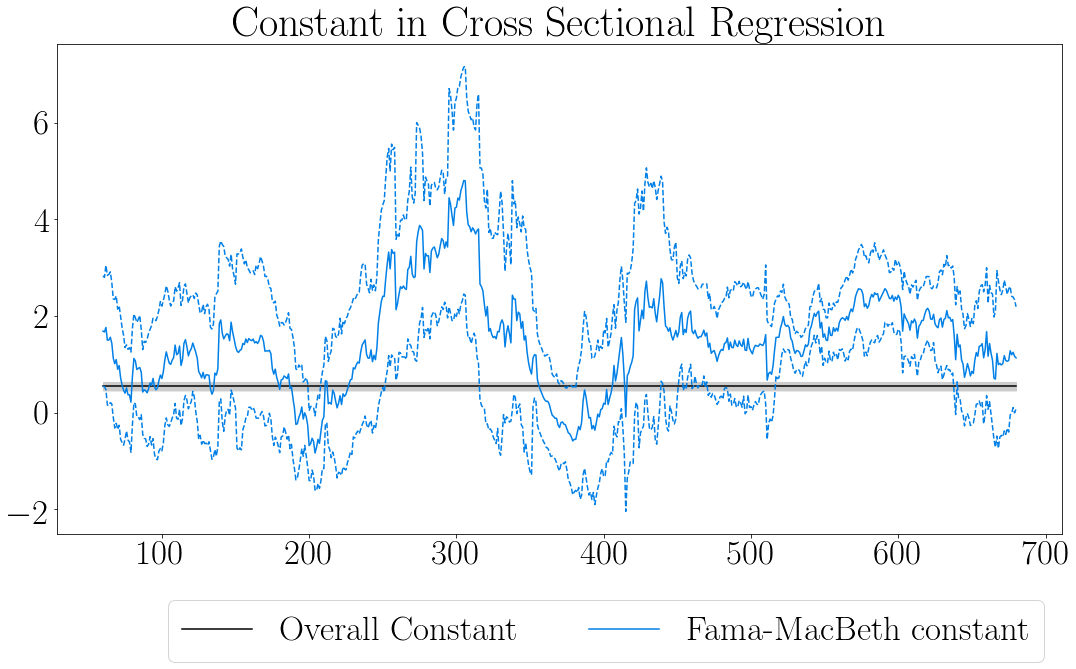

In [251]:
timeVarying = (α_TS,α_TS_se,β,β_se_NW,λ,λ_se,α_CS,c,c_se,ER,nice_df)
constants=(β_Q3,seNW_Q3,Factorfitted,resid,λ_constant,seWhite_constant)
plotFamaMacBethNice(timeVarying,constants,names2Factor,['Mkt-RF','SMB','HML','MoM'],60,doAlpha=False\
                    ,doBetaCorner=False,doConstant=True,doPremiumGraph=False)


> *The plot above shows the single regression and then Fama-Macbeth estimates of the constant in the cross sectional regression. As can be seen, we can clearly reject that this regression coefficient is constant over time. Next let's look at the $\beta$s of the corner portfolio bins* 

IntProgress(value=0, max=16)

Market β`s Fama Macbeth


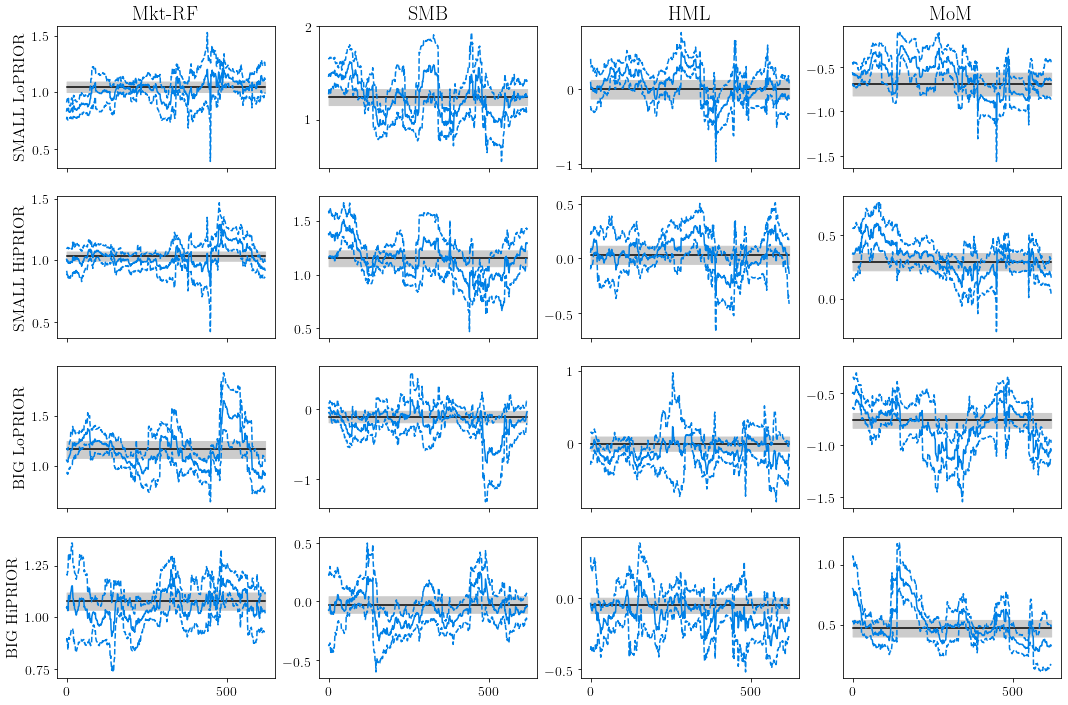

In [252]:
plotFamaMacBethNice(timeVarying,constants,names2Factor,['Mkt-RF','SMB','HML','MoM'],60,doAlpha=False\
                    ,doBetaCorner=True,doConstant=False,doPremiumGraph=False)

IntProgress(value=0, max=25)

Market α`s Fama Macbeth
N.B. Can`t do standard errors for the cross sectional alpha estimates. They are regression residuals!


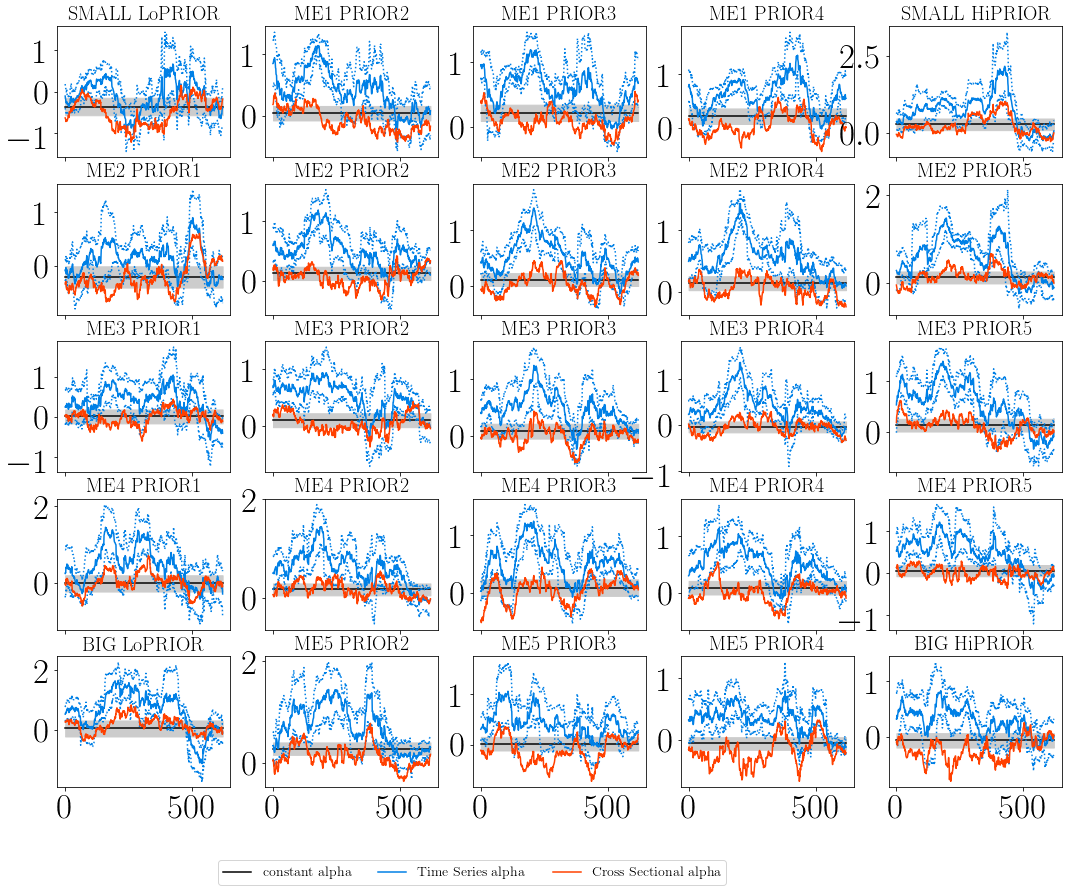

In [253]:
plotFamaMacBethNice(timeVarying,constants,names2Factor,['Mkt-RF','SMB','HML','MoM'],60,doAlpha=True\
                    ,doBetaCorner=False,doConstant=False,doPremiumGraph=False)

> *As can be seen here, the $\alpha$s move around a lot and in most cases we can reject that $\alpha$s are constant **and** we can reject that the $\alpha$s are 0. This is still a rejection of mean-variance efficiency! Note also that we should be getting that the $\alpha$s from the cross sectional regressions be equal to the Factor Premiums. Let's check this next*

IntProgress(value=0, max=4)

Does expected premium match λ?


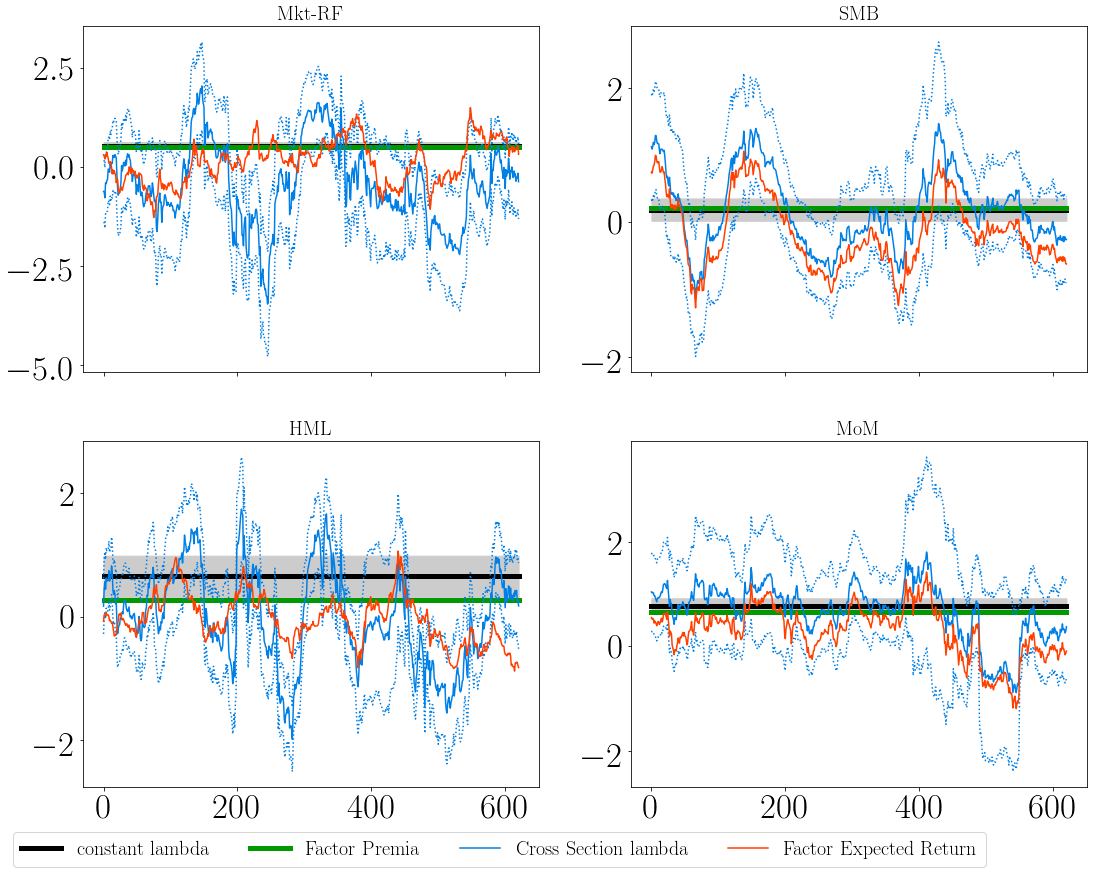

In [271]:
plotFamaMacBethNice(timeVarying,constants,names2Factor,['Mkt-RF','SMB','HML','MoM'],60,doAlpha=False\
                    ,doBetaCorner=False,doConstant=False,doPremiumGraph=True)

> *Looking at this we see the following:*
> 1. *The expected premiums and $\lambda$ estimates are clearly not constant.*
> 2. *If these factors are excess returns and the factors collectively are all MV efficient, then the $\lambda$s are supposed to estimate the average risk premium over the sample being considered. We see clear evidence of this being the case for the MoM factor and SMB factors and some evidence for HML. We see no evidence of this for the CAPM factor.*

In [273]:
λ.mean()

Mkt-RF   -0.430450
SMB       0.186227
HML      -0.013767
MoM       0.677791
dtype: float64

In [274]:
ER.mean()

Mkt-RF    0.132591
SMB      -0.143954
HML      -0.046537
MoM       0.282821
dtype: float64